In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mpl_col
import matplotlib.cm as cm
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from collections import Counter, namedtuple, OrderedDict
from itertools import izip
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import sys
import re
import json
from scipy.stats import ks_2samp, mannwhitneyu

from IPython.display import display

In [4]:
from matplotlib_venn import venn2

In [5]:
import pop_stats_tools as tools
import pop_stats_plotting_tools as pt

# Plotting settings

In [6]:
pd.options.display.max_columns = 999
pd.options.display.max_rows = 100
pd.set_option('display.max_colwidth', 200)

In [7]:
sns.set_context("paper")
sns.set(font_scale=1.5, font='Arial')

In [8]:
cpool = ["#cccccc", "#B6B6B6", "#440647", "#424B80"]
cmap4 = mpl_col.ListedColormap(cpool, 'indexed')
cm.register_cmap(cmap=cmap4)

# Constants

In [9]:
GENES = "./data/genes.txt"

In [10]:
SUPPLEMENT_PATH = "./supp_data/"
RAW_FIGURE_PATH = "./raw_figure/"

In [11]:
POPS = ["AFR", "AMR", "SAS", "EAS", "NFE", "FIN"]

In [12]:
COLOR_MAPPING = {'ADME': '#2A3FA6',
 'All genes': 'grey',
 'Cytochrome': '#2A3FA6',
 'Cytochrome P450s': '#2A3FA6',
 'Target': '#6C226C',
 'Target genes': '#6C226C',
 'other ADME genes': '#2A3FA6',
 'target': '#6C226C',
 'target, ADME': '#6C226C'}

In [13]:
# COLOR_MAPPING = {"Target": "#A6002C", "target": "#A6002C", "Target genes": "#A6002C",
#                  "ADME": "#6C226C", 'other ADME genes': "#6C226C",
#                  "Cytochrome": "#2A3FA6", 'Cytochrome P450s': "#2A3FA6",
#                  "All genes": "grey"}

# Functions

In [14]:
def merge_dicts(*dict_args):
    """
    Given any number of dicts, shallow copy and merge into a new dict,
    precedence goes to key value pairs in latter dicts.
    """
    result = {}
    for dictionary in dict_args:
        result.update(dictionary)
    return result

In [15]:
def reduce_drug2gene(df):
    rdf = df.groupby(['hgnc_id', 'gene_symbol'])\
            .agg({'midrug_id': {'drug_ids': lambda x: ','.join(map(str, x))},
                  'name': {'drug_names': lambda x: ','.join(set(x)),
                           ' n_drugs': lambda x: len(set(x))}})\
            .reset_index()
    return rdf

In [16]:
def get_val(d, k='cat'):
    if isinstance(d, dict):
        return [d.get(k)]
    if isinstance(d, list):
        return [x.get(k) for x in d]
    else:
        return []
    
def get_data(d):
    if isinstance(d, dict):
        return [d.get("consequence"),
                d.get("consdetail"),
                ",".join(get_val(d.get("polyphen"))),
                ",".join(get_val(d.get("sift")))]
    elif d is None:
        return
    else:
        for e in d:
            return [e.get("consequence"),
                    e.get("consdetail"),
                    ",".join(get_val(d.get("polyphen"))),
                    ",".join(get_val(d.get("polyphen")))]

def get_annotation(variant_list):
    output = []
    mv = myvariant.MyVariantInfo()
    for v in variant_list:
        var = mv.getvariant(v)

        if var is None:
            continue
        if isinstance(var, dict):
            all_cons = [var]
#         print v
        for cons in all_cons:
            snpeff = cons.get('snpeff', {}).get("ann", {})
            snpeff_effect = ",".join(get_val(snpeff, 'effect'))
            snpeff_impact = ",".join(get_val(snpeff, 'putative_impact'))

            cons = cons.get("cadd", {})

            if isinstance(cons, dict):
                data = get_data(cons)
                if data is not None:
                    output.append([v, snpeff_effect, snpeff_impact] + data)
            else:
                for c in cons:
                    data = get_data(c)
                    if data is not None:
                        output.append([v, snpeff_effect, snpeff_impact] + data)

    return output

# Data Imports

## Gene data

In [17]:
genes = pd.read_csv(GENES, sep="\t", comment="#")

/Users/schaerfe/Documents/Privat/Dropbox/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (13,19,20,21,22,23,24,26,27,28,29,30,31,32,33,34,35,36,37,38,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Drugs

In [20]:
top_100_drugs = pd.read_csv(SUPPLEMENT_PATH + "top_100_compounds_analysis.txt", sep="\t")

In [21]:
essential_drug_targets = pd.read_csv(SUPPLEMENT_PATH + "who_drugs_with_target.txt", sep="\t")
essential_compounds = essential_drug_targets[u"('midrug_id', '')"].unique()

## Drug-related genes

In [22]:
drug2gene_targets_approved_drugs = pd.read_csv(SUPPLEMENT_PATH + "drug2gene_targets_approved_drugs.txt", sep="\t", encoding='utf-8')

In [23]:
pharmacogenes_df = pd.read_csv(SUPPLEMENT_PATH + "pharmacogenes_set.txt", sep="\t")

In [24]:
# targets_approved_drugs.gene_symbol.tolist(), kozyra_genes, fujikura_genes,
target_genes = pharmacogenes_df.loc[pharmacogenes_df["group"].str.contains("target"), "symbol"].tolist()
adme_genes = pharmacogenes_df.loc[pharmacogenes_df["group"].str.contains("ADME") &
                                  ~pharmacogenes_df["subgroup"].str.contains("CYP"), "symbol"].tolist()
cyp_genes = pharmacogenes_df.loc[pharmacogenes_df["group"].str.contains("ADME") &
                                 pharmacogenes_df["subgroup"].str.contains("CYP"), "symbol"].tolist()

## Variant data

In [25]:
probably_lof_by_gene = pd.read_csv(SUPPLEMENT_PATH + "functional_variants_by_gene.txt", sep="\t")

In [26]:
probably_lof = pd.read_csv(SUPPLEMENT_PATH + "ns_functional_variants_pharmacogenes.txt", sep="\t")

/Users/schaerfe/Documents/Privat/Dropbox/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [27]:
probably_lof_very_rare = probably_lof.loc[probably_lof["COMP.AF_Adj"] < 0.001]

In [28]:
variants_lof = tools.filter_variants(probably_lof,
                                     terms={'LoF': ['HC']})

# CAP scores for genes

In [29]:
summed_AF_functional_all = tools.aggregate_by_gene(probably_lof, populations_prefix='COMP.AF_')
tools.add_allele_probabilities(summed_AF_functional_all, populations_prefix='COMP.AF_')
tools.summarize_allele_probabilities(summed_AF_functional_all, p_col='P_min_one_LoF', populations_prefix='COMP.AF_',)

summed_AF_functional_very_rare = tools.aggregate_by_gene(probably_lof_very_rare, populations_prefix='COMP.AF_')
tools.add_allele_probabilities(summed_AF_functional_very_rare, populations_prefix='COMP.AF_')
tools.summarize_allele_probabilities(summed_AF_functional_very_rare, p_col='P_min_one_LoF',
                                     populations_prefix='COMP.AF_',)

summed_AF_lof_hc = tools.aggregate_by_gene(variants_lof, populations_prefix='COMP.AF_')
tools.add_allele_probabilities(summed_AF_lof_hc, populations_prefix='COMP.AF_')
tools.summarize_allele_probabilities(summed_AF_lof_hc, p_col='P_min_one_LoF', populations_prefix='COMP.AF_')


## Pharmacogenes with highest CAP Score

### All pharmacogenes

#### Probably LoF

In [30]:
pharmacogenes_subset = summed_AF_functional_all.merge(pharmacogenes_df, left_on="SYMBOL", right_on="symbol")
pharmacogenes_subset.sortlevel(inplace=True, axis=1)
prob_lof_all_pharmacogenes = pharmacogenes_subset[[("SYMBOL",""), ("COMP.AF_Adj", "P_min_one_LoF"),
                                                   ("var_uid", "n_deleterious_variants")] +
                                                        pharmacogenes_df.columns.tolist()]\
    .sort_values(by=[("COMP.AF_Adj", "P_min_one_LoF")], ascending=False)
prob_lof_all_pharmacogenes.head(50).to_csv(SUPPLEMENT_PATH + "top50_probability_functional_all_pharmacogenes.txt",
                                        index=False, sep="\t")

/Users/schaerfe/Documents/Privat/Dropbox/anaconda/lib/python2.7/site-packages/pandas/tools/merge.py:536: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


#### Probably LoF - rare variants only

In [31]:
pharmacogenes_subset_rare = summed_AF_functional_very_rare.merge(pharmacogenes_df, left_on="SYMBOL", right_on="symbol")
pharmacogenes_subset_rare.sortlevel(inplace=True, axis=1)
prob_lof_all_pharmacogenes_rareCAP = pharmacogenes_subset_rare[[("SYMBOL",""), ("COMP.AF_Adj", "P_min_one_LoF"),
                                                   ("var_uid", "n_deleterious_variants")] +
                                                        pharmacogenes_df.columns.tolist()]\
    .sort_values(by=[("COMP.AF_Adj", "P_min_one_LoF")], ascending=False)
prob_lof_all_pharmacogenes_rareCAP.head(50).to_csv(SUPPLEMENT_PATH +
                                                   "top50_probability_rare_functional_all_pharmacogenes.txt",
                                                   index=False, sep="\t")

In [32]:
prob_lof_all_pharmacogenes_rareCAP.head()

,"(SYMBOL, )","(COMP.AF_Adj, P_min_one_LoF)","(var_uid, n_deleterious_variants)",hgnc_id,symbol,uniprot_ids,length,group,subgroup
0,SCN10A,0.037166,409,10582,SCN10A,Q9Y5Y9,1956.0,target,target
1,ABCB5,0.032380,318,46,ABCB5,Q2M3G0,1257.0,ADME,transporter
2,ACE,0.029123,271,2707,ACE,P12821,1306.0,target,target
3,CFTR,0.028923,282,1884,CFTR,P13569,1480.0,target,target
4,ABCA4,0.027792,416,34,ABCA4,P78363,2273.0,ADME,transporter


#### LoF

In [33]:
pharmacogenes_subset_lof = summed_AF_lof_hc.merge(pharmacogenes_df, left_on="SYMBOL", right_on="symbol")
pharmacogenes_subset_lof.sortlevel(inplace=True, axis=1)
prob_lof_all_pharmacogenes = pharmacogenes_subset_lof[[("SYMBOL",""), ("COMP.AF_Adj", "P_min_one_LoF"),
                                                   ("var_uid", "n_deleterious_variants")] +
                                                        pharmacogenes_df.columns.tolist()]\
    .sort_values(by=[("COMP.AF_Adj", "P_min_one_LoF")], ascending=False)
prob_lof_all_pharmacogenes.head(50).to_csv(SUPPLEMENT_PATH + "top50_probability_LoF_all_pharmacogenes.txt",
                                        index=False, sep="\t")

In [34]:
prob_lof_all_pharmacogenes.head()

,"(SYMBOL, )","(COMP.AF_Adj, P_min_one_LoF)","(var_uid, n_deleterious_variants)",hgnc_id,symbol,uniprot_ids,length,group,subgroup
0,CYP2F1,0.384055,18,2632,CYP2F1,P24903,491.0,ADME,CYP450
1,CYP4B1,0.274345,23,2644,CYP4B1,P13584,511.0,ADME,CYP450
2,GSTT2,0.268632,1,4642,GSTT2,P0CG29,244.0,ADME,phase II enzyme
4,ABCB5,0.220355,69,46,ABCB5,Q2M3G0,1257.0,ADME,transporter
3,FCGR2A,0.195876,9,3616,FCGR2A,P12318,317.0,target,target


#### Create single table with different CAP scores for each pharmacogene -- Supplemental Table X

In [35]:
pg_ss = pharmacogenes_subset[[("SYMBOL",""), ("var_uid", "n_deleterious_variants"),
                              ("COMP.AF_Adj", "P_min_one_LoF")]]
pg_ss.columns = ["symbol", "functional variants", "CAP_functional"]

pg_rare_ss = pharmacogenes_subset_rare[[("SYMBOL",""), ("var_uid", "n_deleterious_variants"),
                                        ("COMP.AF_Adj", "P_min_one_LoF")]]
pg_rare_ss.columns = ["symbol", "rare functional variants", "CAP_rare_functional"]

pg_LoF_ss = pharmacogenes_subset_lof[[("SYMBOL",""), ("var_uid", "n_deleterious_variants"),
                                      ("COMP.AF_Adj", "P_min_one_LoF")]]
pg_LoF_ss.columns = ["symbol", "LoF variants", "CAP_LoF"]

pharmacogenes_CAP = pharmacogenes_df.merge(pg_ss, how='outer').merge(pg_rare_ss, how='outer').merge(pg_LoF_ss, how='outer')

In [36]:
pharmacogenes_CAP = pharmacogenes_CAP.sort_values(by=["CAP_functional"], ascending=False)

In [37]:
# pharmacogenes_CAP = pharmacogenes_CAP.merge(probably_lof_by_gene.reset_index(), left_on="symbol", right_on="SYMBOL")\
#     .sort_values(by=["CAP_functional"], ascending=False)

In [38]:
# pharmacogenes_CAP.drop([('SYMBOL', ''), ('HGNC_ID', ''), ('var_uid', 'unique_variants'), ('SYMBOL', '')], axis=1, inplace=True)

In [39]:
pharmacogenes_CAP.to_csv(SUPPLEMENT_PATH + "CAP_pharmacogenes.txt", sep="\t", index=False, float_format='%.5f')

In [40]:
COLOR_MAPPING['target, ADME'] = "#6C226C"
COLOR_MAPPING['target'] = "#6C226C"
COLOR_MAPPING['ADME'] = "#2A3FA6"

/Users/schaerfe/Documents/Privat/Dropbox/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/schaerfe/Documents/Privat/Dropbox/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/schaerfe/Documents/Privat/Dropbox/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_l

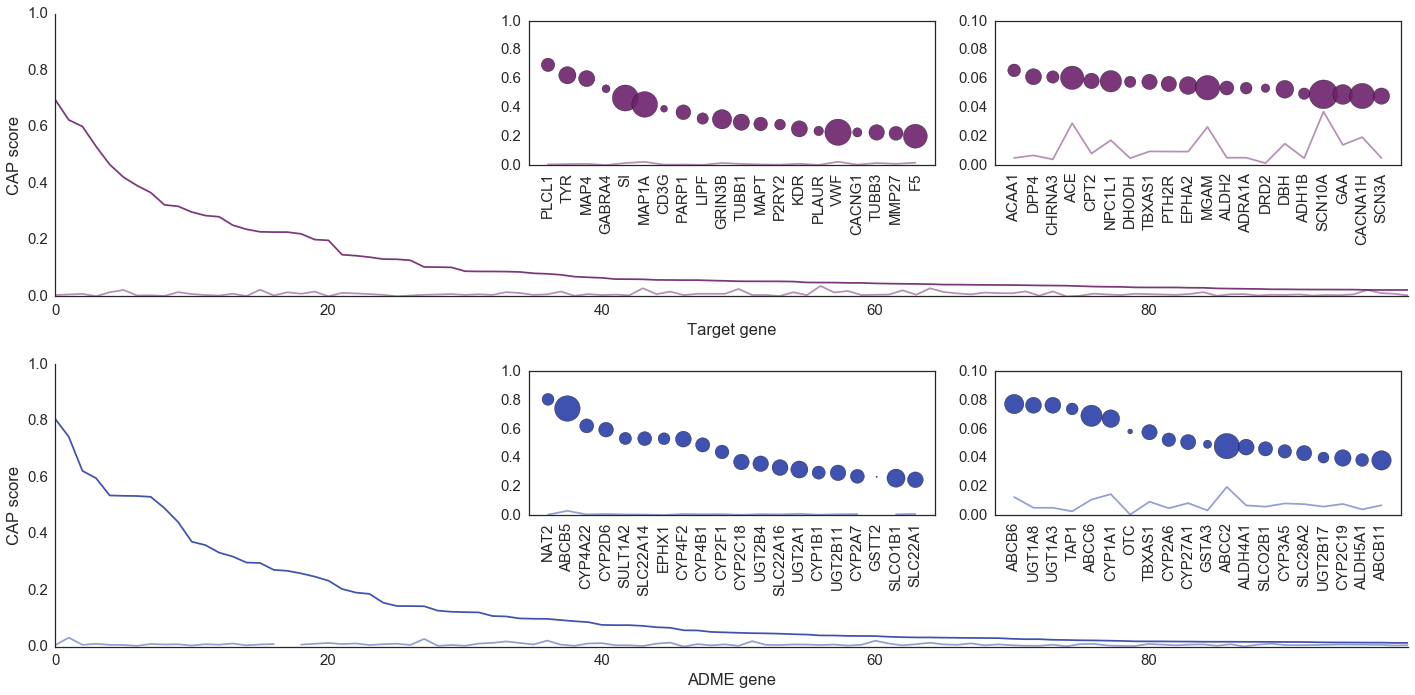

In [41]:
from mpl_toolkits.axes_grid.inset_locator import inset_axes
with sns.axes_style("white"):
    subset_all = pharmacogenes_CAP.sort_values(by=["CAP_functional"], ascending=False)
    pharmacogenes_CAP_pd = pharmacogenes_CAP.loc[pharmacogenes_CAP["group"].str.contains('target')]
    pharmacogenes_CAP_pk = pharmacogenes_CAP.loc[pharmacogenes_CAP["group"].str.contains('ADME')]
    
    pharmacogenes_CAP_pd.loc[:, 'i'] = pharmacogenes_CAP_pd.reset_index().index
    pharmacogenes_CAP_pk.loc[:, 'i'] = pharmacogenes_CAP_pk.reset_index().index
    subset_t = pharmacogenes_CAP_pd[:20]
    subset_a = pharmacogenes_CAP_pk[:20]
    subset_t_rare = pharmacogenes_CAP_pd[40:60]
    subset_a_rare = pharmacogenes_CAP_pk[40:60]
    
    fig, (ax, ax3) = plt.subplots(2, 1, figsize=(20, 10))

    ax2 = inset_axes(ax, 
                    width="30%", # width = 30% of parent_bbox
                    height=2.0, # height : 1 inch
                    loc=9, 
                    )
    ax5 = inset_axes(ax, 
                    width="30%", # width = 30% of parent_bbox
                    height=2.0, # height : 1 inch
                    loc=1)

    ax4 = inset_axes(ax3, 
                    width="30%", # width = 30% of parent_bbox
                    height=2.0, # height : 1 inch
                    loc=9, 
                    )
    ax6 = inset_axes(ax3, 
                    width="30%", # width = 30% of parent_bbox
                    height=2.0, # height : 1 inch
                    loc=1)
    
    
    pharmacogenes_CAP_pd[:100].plot('i', 'CAP_functional',
                    ax=ax,
                    c=COLOR_MAPPING['target'],
                    alpha=0.9)
    pharmacogenes_CAP_pd[:100].plot('i', 'CAP_rare_functional',
                    ax=ax,
                    c=COLOR_MAPPING['target'],
                    alpha=0.5)
    ax2.scatter(subset_t['i'], subset_t['CAP_functional'],
                    marker='o',
                    s=subset_t["functional variants"] * 2,
                    c="#6C226C",
                    alpha=0.9)
    ax2.plot(subset_t['i'], subset_t['CAP_rare_functional'],
                    color="#6C226C",
                    alpha=0.5)
    
    ax5.scatter(subset_t_rare['i'], subset_t_rare['CAP_functional'],
                    marker='o',
                    s=subset_t_rare["functional variants"] * 2,
                    c="#6C226C",
                    alpha=0.9)
    ax5.plot(subset_t_rare['i'], subset_t_rare['CAP_rare_functional'],
                    color="#6C226C",
                    alpha=0.5)

    pharmacogenes_CAP_pk[:100].plot('i', 'CAP_functional',
                    ax=ax3,
                    c=COLOR_MAPPING['ADME'],
                    alpha=0.9)
    pharmacogenes_CAP_pk[:100].plot('i', 'CAP_rare_functional',
                    ax=ax3,
                    c=COLOR_MAPPING['ADME'],
                    alpha=0.5)
    ax4.scatter(subset_a['i'], subset_a['CAP_functional'],
                    marker='o',
                    s=subset_a["functional variants"] * 2,
                    c="#2A3FA6",
                    alpha=0.9)
    ax4.plot(subset_a['i'], subset_a['CAP_rare_functional'],
                    color="#2A3FA6",
                    alpha=0.5)
    
    
    ax6.scatter(subset_a_rare['i'], subset_a_rare['CAP_functional'],
                    marker='o',
                    s=subset_a_rare["functional variants"] * 2,
                    c="#2A3FA6",
                    alpha=0.9)
    ax6.plot(subset_a_rare['i'], subset_a_rare['CAP_rare_functional'],
                    color="#2A3FA6",
                    alpha=0.5)

    num_vars = set(subset_a["functional variants"].tolist() + subset_t["functional variants"].tolist())
    min_exp, max_exp = int(np.log10(min(num_vars))), int(np.log10(max(num_vars)))
    
    ax2.set_xlim(-1, len(subset_t))
    ax2.set_xticks(subset_t['i'],)
    ax2.set_xticklabels([str(i) for i in subset_t['symbol']],
                       rotation='vertical')
    
    ax4.set_xlim(-1, len(subset_a))
    ax4.set_xticks(subset_a['i'],)
    ax4.set_xticklabels([str(i) for i in subset_a['symbol']],
                        rotation='vertical')
    
    
    ax5.set_xlim(subset_t_rare['i'].min() -1, subset_t_rare['i'].max() + 1)
    ax5.set_xticks(subset_t_rare['i'],)
    ax5.set_xticklabels([str(i) for i in subset_t_rare['symbol']],
                        rotation='vertical')
    ax6.set_xlim(subset_a_rare['i'].min() - 1, subset_a_rare['i'].max() + 1)
    ax6.set_xticks(subset_a_rare['i'],)
    ax6.set_xticklabels([str(i) for i in subset_a_rare['symbol']],
                        rotation='vertical')
    
    t = mpatches.Patch(color="#6C226C", label='Target')
    a = mpatches.Patch(color="#2A3FA6", label='ADME')     
    
    ax2.set_ylim(0.0, 1.0)
    ax4.set_ylim(0.0, 1.0)
    ax.set_ylim(0.0, 1.0)
    ax3.set_ylim(0.0, 1.0)
    ax5.set_ylim(0.0, 0.1)
    ax6.set_ylim(0.0, 0.1)

    for a in (ax,):
        a.set_xlabel('Target gene')
        a.set_ylabel('CAP score')
        a.set_axisbelow(True)
        sns.despine(top=True, right=True, bottom=False, ax=a)
    for a in (ax3,):
        a.set_xlabel('ADME gene')
        a.set_ylabel('CAP score')
        a.set_axisbelow(True)
        sns.despine(top=True, right=True, bottom=False, ax=a)
    plt.tight_layout()
    plt.savefig(RAW_FIGURE_PATH + "pgx_genes_high_cap.pdf", dpi=300)

In [42]:
import matplotlib.lines as mlines

In [43]:
# len(subset_all.loc[subset_all["cap_fraction_rare"] == 1.0])

In [44]:
# len(subset_all.loc[subset_all["cap_fraction_rare"] > .33])

In [45]:
# pharmacogenes_CAP

### Drug Targets only

#### LoF

In [46]:
targets_approved_drugs_subset = summed_AF_lof_hc.loc[summed_AF_lof_hc[("SYMBOL", "")].isin(target_genes)]

In [47]:
top_30_lof = targets_approved_drugs_subset[[("SYMBOL",""), ("COMP.AF_Adj", "P_min_one_LoF")]]\
    .sort_values(by=[("COMP.AF_Adj", "P_min_one_LoF")], ascending=False).head(30)

#### Probably LoF

In [48]:
targets_approved_drugs_subset = summed_AF_functional_all.loc[summed_AF_functional_all[("SYMBOL", "")]\
                                                      .isin(target_genes)]
targets_approved_drugs_subset.sortlevel(inplace=True, axis=1)
targets_approved_drugs_subset.SYMBOL.nunique()

/Users/schaerfe/Documents/Privat/Dropbox/anaconda/lib/python2.7/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  inplace=inplace, sort_remaining=sort_remaining)


628

In [49]:
# top_30_prob_lof = targets_approved_drugs_subset[[("SYMBOL",""), ("COMP.AF_Adj", "P_min_one_LoF")]]\
#     .sort_values(by=[("COMP.AF_Adj", "P_min_one_LoF")], ascending=False)\
#     .merge(targets_approved_drugs, left_on=[("SYMBOL", "")],
#                                         right_on=[("gene_symbol", "")])\
#     .merge(pharmacogenes_df, left_on=[("gene_symbol", "")], right_on="symbol")
# top_30_prob_lof = top_30_prob_lof.drop([("gene_symbol", ""), ("hgnc_id", ""), 'hgnc_id', 'symbol'], axis=1)
# top_30_prob_lof.to_csv(SUPPLEMENT_PATH + "top30_probability_functional_targets.txt", index=False, sep="\t",
#                        float_format='%.5f')

### Cancer target genes

In [50]:
pharmacogenes_CAP.loc[pharmacogenes_CAP.subgroup.str.contains("cancer target")].head(10)

,hgnc_id,symbol,uniprot_ids,length,group,subgroup,functional variants,CAP_functional,rare functional variants,CAP_rare_functional,LoF variants,CAP_LoF
432,6862,MAP4,P27816,1152.0,target,cancer target,131.0,0.601222,126.0,0.009194,3.0,0.000066
428,6835,MAP1A,P78559,2803.0,target,cancer target,330.0,0.421974,325.0,0.022941,8.0,0.000150
120,1675,CD3G,P09693,182.0,target,cancer target,24.0,0.392043,23.0,0.003544,8.0,0.000696
34,270,PARP1,P09874,1014.0,target,cancer target,110.0,0.367402,108.0,0.004342,18.0,0.000368
744,16257,TUBB1,Q9H4B7,451.0,target,cancer target,134.0,0.298537,129.0,0.008704,19.0,0.001205
436,6893,MAPT,P10636,758.0,target,cancer target,94.0,0.286037,91.0,0.005121,15.0,0.000621
417,6307,KDR,P35968,1356.0,target,cancer target,131.0,0.252081,127.0,0.009753,11.0,0.002840
793,20772,TUBB3,Q13509,450.0,target,cancer target,121.0,0.227604,114.0,0.014771,17.0,0.008562
548,9542,PSMB5,P28074,263.0,target,cancer target,23.0,0.131511,22.0,0.000776,1.0,0.000016
486,8031,NTRK1,P04629,796.0,target,cancer target,108.0,0.088419,107.0,0.005645,15.0,0.000334


In [51]:
len(pharmacogenes_CAP.loc[(pharmacogenes_CAP.subgroup.str.contains("cancer target")) & (pharmacogenes_CAP["CAP_functional"] > 0.01) ])

40

# Drug Risk Probability (DRP) for functional variant in any target

## Create tables

### LoF variants only

In [52]:
drugs_AF_lof_hc = tools.aggregate_accross_genes(summed_AF_lof_hc, drug2gene_targets_approved_drugs, detailed=False)
tools.summarize_drug_probabilities(drugs_AF_lof_hc, p_col_temp=("COMP.AF_{}", "P_no_LoF", "P_var_in_any"))

In [53]:
sorted_columns = [c for c in drugs_AF_lof_hc.columns if not c[0].startswith("COMP")] +\
                 [("COMP.AF_" + p, "P_no_LoF", "P_var_in_any") for p in ["Adj"] + POPS]
drugs_AF_lof_hc = drugs_AF_lof_hc[sorted_columns]
drugs_AF_lof_hc.columns.set_levels(["COMP.AF_Adj_hc" if x == "COMP.AF_Adj" else x 
                                    for x in drugs_AF_lof_hc.columns.levels[0]], 0, inplace=True)

### Functional variants

#### P(min one functional) based on all functional variants

In [54]:
drugs_AF_lof = tools.aggregate_accross_genes(summed_AF_functional_all, drug2gene_targets_approved_drugs, detailed=False)
tools.summarize_drug_probabilities(drugs_AF_lof, p_col_temp=("COMP.AF_{}", "P_no_LoF", "P_var_in_any"))

In [55]:
sorted_columns = [c for c in drugs_AF_lof.columns if not c[0].startswith("COMP")] +\
                 [("COMP.AF_" + p, "P_no_LoF", "P_var_in_any") for p in ["Adj"] + POPS]
drugs_AF_lof = drugs_AF_lof[sorted_columns]

In [56]:
len(drugs_AF_lof.loc[drugs_AF_lof[("COMP.AF_Adj", "P_no_LoF", "P_var_in_any")] >= 0.01])/float(len(drugs_AF_lof))

0.42753036437246966

#### P(min one functional) based on rare functional variants only

In [57]:
drugs_AF_lof_rare = tools.aggregate_accross_genes(summed_AF_functional_very_rare, drug2gene_targets_approved_drugs, detailed=False)
tools.summarize_drug_probabilities(drugs_AF_lof_rare, p_col_temp=("COMP.AF_{}", "P_no_LoF", "P_var_in_any"))

In [58]:
sorted_columns = [c for c in drugs_AF_lof_rare.columns if not c[0].startswith("COMP")] +\
                 [("COMP.AF_" + p, "P_no_LoF", "P_var_in_any") for p in ["Adj"] + POPS]
drugs_AF_lof_rare = drugs_AF_lof_rare[sorted_columns]

## Combine different DRP scores -- supplemental table

In [59]:
len(drugs_AF_lof), len(drugs_AF_lof_rare), len(drugs_AF_lof_hc)

(1235, 1235, 1164)

In [60]:
include_cols = [("SYMBOL", "", "n_targets"), ("SYMBOL", "", "targets"),
                ("var_uid", "n_deleterious_variants", "n_variants"), 
                ("COMP.AF_Adj_all", "P_no_LoF", "P_var_in_any"),
                ("COMP.AF_Adj_rare_only", "P_no_LoF", "P_var_in_any"),
                ("COMP.AF_Adj_hc", "P_no_LoF", "P_var_in_any")]
DRP_scores_all_drugs = drugs_AF_lof.join(drugs_AF_lof_rare[("COMP.AF_Adj", "P_no_LoF", "P_var_in_any")],
                                         lsuffix="_all", rsuffix="_rare_only")\
                                   .join(drugs_AF_lof_hc[("COMP.AF_Adj_hc", "P_no_LoF", "P_var_in_any")], how='left')
DRP_scores_all_drugs = DRP_scores_all_drugs[include_cols]
DRP_scores_all_drugs.columns = ['n_targets', 'targets', 'n_functional_variants',
                                'DRP_functional', 'DRP_rare_functional', 'DRP_LoF']

In [61]:
no_lof_targets = sorted(set([y.strip() for x in DRP_scores_all_drugs.loc[DRP_scores_all_drugs['DRP_LoF'].isnull()].targets.unique()
                 for y in x.split(",")]))
print ", ".join(no_lof_targets),
print "(total:", len(no_lof_targets), ") target genes do not have any high confidence LoF variant."

ACHE, AR, BTK, CHRM1, CHRM3, FKBP1A, GABRB3, HTR1A, PTGS2, RPL3, SERPINC1, SLC6A1, SNAP25, TNFSF13B, TOP1 (total: 15 ) target genes do not have any high confidence LoF variant.


In [62]:
DRP_scores_all_drugs = DRP_scores_all_drugs.reset_index()
DRP_scores_all_drugs = DRP_scores_all_drugs.merge(top_100_drugs[['midrug_id',
                                                                 'top100_units_Rank_top',
                                                                 'top100_units_Rank_all',
                                                                 'top100_sales_Rank_top',
                                                                 'top100_sales_Rank_all']],
                                                  on='midrug_id', how='left')
DRP_scores_all_drugs["essential_medicines"] = DRP_scores_all_drugs["midrug_id"].isin(essential_compounds)
DRP_scores_all_drugs.to_csv(SUPPLEMENT_PATH + "DRP_all_drugs.txt", sep="\t", index=False,
                                         float_format='%.5f')

In [63]:
len(DRP_scores_all_drugs.loc[DRP_scores_all_drugs["DRP_functional"] > 0.01])

530

## Highest ranking drugs

### Drugs with highest DRP

#### Functional DRP

In [64]:
temp_df_functional = DRP_scores_all_drugs\
    .groupby([x for x in DRP_scores_all_drugs.columns if x not in ['name', 'midrug_id', 'essential_medicines']
              and not x.startswith('top100')])\
    .agg({'name': lambda x: ','.join(sorted(x))})\
    .reset_index()\
    .sort_values(by=["DRP_functional"], ascending=False)
G = pt.tree_from_df(temp_df_functional[:10], drug_size_col='DRP_functional',
                    target_name_col='targets',
                    gene_p_lof=pharmacogenes_CAP, gene_name_col=('symbol'),
                    gene_size_col='CAP_functional', multiindex=False)
html, js = pt.plot_interactive_treemap_v2(G, div_id="highest_DRP")
display(html)
display(js)

<IPython.core.display.Javascript object>

In [65]:
temp_df_functional.head()

,n_targets,targets,n_functional_variants,DRP_functional,DRP_rare_functional,DRP_LoF,name
517,5,"MAP2, BCL2, MAPT, MAP4, TUBB1",621,0.817679,0.035221,0.002074,Paclitaxel
483,4,"MAP2, MAPT, MAP4, TUBB1",606,0.817620,0.034910,0.002040,Docetaxel
425,3,"PLA2G6, PLA2G4A, PLCL1",232,0.698283,0.010971,0.001064,Quinacrine
231,2,"AKR1D1, TYR",211,0.625447,0.010118,0.002099,Azelaic Acid
561,18,"GABRB3, GABRG3, GABRR1, GABRR2, GABRG2, GABRQ, GABRP, GABRA5, GABRA3, GABRD, GABRE, GABRA4, GABRB2, GABRA6, GABRA1, GABRG1, GABRB1, GABRA2",781,0.563960,0.039948,0.003749,"Bromazepam,Flurazepam,Midazolam,Nitrazepam,Oxazepam,Temazepam,Triazolam"


#### Rare functional DRP

In [66]:
temp_df_rare_functional = DRP_scores_all_drugs\
    .groupby([x for x in DRP_scores_all_drugs.columns if x not in ['name', 'midrug_id', 'essential_medicines']
              and not x.startswith('top100')])\
    .agg({'name': lambda x: ','.join(sorted(x))})\
    .reset_index()\
    .sort_values(by=["DRP_rare_functional"], ascending=False)
G = pt.tree_from_df(temp_df_rare_functional[:10], drug_size_col='DRP_rare_functional',
                    target_name_col='targets',
                    gene_p_lof=pharmacogenes_CAP, gene_name_col=('symbol'),
                    gene_size_col='CAP_rare_functional', multiindex=False)
html, js = pt.plot_interactive_treemap_v2(G, div_id="highest_rare_DRP")
display(html)
display(js)

<IPython.core.display.Javascript object>

In [67]:
temp_df_rare_functional.head()

,n_targets,targets,n_functional_variants,DRP_functional,DRP_rare_functional,DRP_LoF,name
563,21,"MMP14, MMP15, MMP24, MMP17, MMP10, MMP11, MMP16, MMP13, MMP21, MMP19, MMP3, MMP28, MMP8, MMP9, MMP25, MMP7, MMP27, MMP26, MMP2, MMP20, MMP1",1769,0.455667,0.115343,0.082606,Marimastat
556,14,"CACNA1H, SCN11A, SCN4B, CACNA1I, CACNA1G, SCN9A, SCN2B, SCN2A, SCN1B, SCN1A, SCN4A, SCN5A, SCN3A, SCN3B",1958,0.224148,0.101226,0.004261,Zonisamide
562,18,"PDGFRB, PDGFRA, TEK, FRK, RAF1, KIT, NTRK1, RET, EPHA2, DDR2, BRAF, MAPK11, ABL1, FLT4, FGFR1, FGFR2, KDR, FLT1",1560,0.406049,0.080365,0.005828,Regorafenib
438,3,"SCN5A, SCN10A, SCN9A",891,0.114055,0.068843,0.002702,"Lidocaine,Lidocaine"
471,4,"GANC, MGAM, GANAB, GAA",807,0.205631,0.060314,0.010757,Miglitol


#### HC LoF DRP

In [68]:
temp_df_lof = DRP_scores_all_drugs\
    .groupby([x for x in DRP_scores_all_drugs.columns if x not in ['name', 'midrug_id', 'essential_medicines']
              and not x.startswith('top100')])\
    .agg({'name': lambda x: ','.join(sorted(x))})\
    .reset_index()\
    .sort_values(by=["DRP_LoF"], ascending=False)
G = pt.tree_from_df(temp_df_lof[:10], drug_size_col='DRP_LoF',
                    target_name_col='targets',
                    gene_p_lof=pharmacogenes_CAP, gene_name_col='symbol',
                    gene_size_col='CAP_LoF', multiindex=False)
html, js = pt.plot_interactive_treemap_v2(G, div_id="highest_lof_DRP")
display(html)
display(js)

<IPython.core.display.Javascript object>

In [69]:
temp_df_lof.head()

,n_targets,targets,n_functional_variants,DRP_functional,DRP_rare_functional,DRP_LoF,name
551,10,"C4B, FCGR2B, FCGR3A, FCGR3B, FCGR1B, FCGR1A, C3, FCGR2A, C5, C4A",450,0.244968,0.022132,0.198209,Immune Globulin Human
563,21,"MMP14, MMP15, MMP24, MMP17, MMP10, MMP11, MMP16, MMP13, MMP21, MMP19, MMP3, MMP28, MMP8, MMP9, MMP25, MMP7, MMP27, MMP26, MMP2, MMP20, MMP1",1769,0.455667,0.115343,0.082606,Marimastat
259,2,"EGF, FGF2",150,0.089722,0.006159,0.082242,Sucralfate
39,1,CES1,88,0.144214,0.010876,0.060086,Oseltamivir
65,1,DPP4,130,0.061414,0.006795,0.056272,"Alogliptin,Linagliptin,Saxagliptin,Sitagliptin,Vildagliptin"


### Top 100 drugs

In [70]:
DRP_scores_all_drugs_top100 = DRP_scores_all_drugs.loc[~DRP_scores_all_drugs.top100_units_Rank_top.isnull()]

In [71]:
len(DRP_scores_all_drugs_top100)

77

In [72]:
len(DRP_scores_all_drugs_top100.loc[DRP_scores_all_drugs_top100.DRP_functional >= 0.01])/float(len(DRP_scores_all_drugs_top100))

0.4155844155844156

In [73]:
DRP_scores_all_drugs_top100.DRP_functional.max()

0.14421378845682464

In [74]:
top_DRP_scores_all_drugs_top100 = DRP_scores_all_drugs\
    .loc[~DRP_scores_all_drugs.top100_units_Rank_top.isnull()]\
    .groupby([x for x in DRP_scores_all_drugs.columns if x not in ['name', 'midrug_id', 'essential_medicines']
              and not x.startswith('top100')])\
    .agg({'name': lambda x: ','.join(x), 'top100_units_Rank_all': lambda x: ';'.join(x)})\
    .reset_index()\
    .sort_values(by=["DRP_functional"], ascending=False)

In [75]:
len(top_DRP_scores_all_drugs_top100)

50

In [76]:
G = pt.tree_from_df(top_DRP_scores_all_drugs_top100[:5], drug_size_col='DRP_LoF',
                    target_name_col='targets',
                    gene_p_lof=pharmacogenes_CAP, gene_name_col='symbol',
                    gene_size_col='CAP_LoF', multiindex=False)
html, js = pt.plot_interactive_treemap_v2(G, div_id="top_DRP_scores_all_drugs_top100")
display(html)
display(js)

<IPython.core.display.Javascript object>

#### Probability of having variant in any top 100 drugs targets

Calculate probability that at least one drug is affected, by calculating P(no drug is affected) and taking the inverse.

In [77]:
1 - np.product([1. - x for x in DRP_scores_all_drugs_top100.DRP_functional])

0.80812893854207946

#### Asthma drugs

In [78]:
top_15_asthma_meds = ["Budesonide", "Salbutamol", "Salmeterol", "Fluticasone Propionate", "Tiotropium"]

In [79]:
DRP_scores_all_drugs_top100.loc[DRP_scores_all_drugs_top100.name.isin(top_15_asthma_meds)]

,name,midrug_id,n_targets,targets,n_functional_variants,DRP_functional,DRP_rare_functional,DRP_LoF,top100_units_Rank_top,top100_units_Rank_all,top100_sales_Rank_top,top100_sales_Rank_all,essential_medicines
916,Salbutamol,991,1,ADRB2,29,0.002539,0.002539,0.000066,3.0,"10, 3, 70, 71",NaN,NaN,True
918,Salmeterol,928,1,ADRB2,29,0.002539,0.002539,0.000066,6.0,6,6.0,6.0,False
1023,Fluticasone Propionate,578,1,NR3C1,49,0.001684,0.001684,0.000165,6.0,"32, 6",6.0,"52.0, 6.0",False
1024,Budesonide,1210,1,NR3C1,49,0.001684,0.001684,0.000165,1.0,"1, 26",30.0,"57.0, 30.0",True
1180,Tiotropium,1357,1,CHRM3,21,0.000595,0.000595,NaN,14.0,14,12.0,12.0,False


### Essential medicines

In [80]:
top_DRP_scores_all_drugs_essential = DRP_scores_all_drugs.drop_duplicates()\
    .loc[DRP_scores_all_drugs.essential_medicines]\
    .groupby([x for x in DRP_scores_all_drugs.columns if x not in ['name', 'midrug_id', 'essential_medicines']
              and not x.startswith('top100')])\
    .agg({'name': lambda x: ','.join(x)})\
    .reset_index()\
    .sort_values(by=["DRP_functional"], ascending=False)

In [81]:
top_DRP_scores_all_drugs_essential.head()

,n_targets,targets,n_functional_variants,DRP_functional,DRP_rare_functional,DRP_LoF,name
111,5,"MAP2, BCL2, MAPT, MAP4, TUBB1",621,0.817679,0.035221,0.002074,Paclitaxel
104,4,"MAP2, MAPT, MAP4, TUBB1",606,0.817620,0.034910,0.002040,Docetaxel
118,18,"GABRB3, GABRG3, GABRR1, GABRR2, GABRG2, GABRQ, GABRP, GABRA5, GABRA3, GABRD, GABRE, GABRA4, GABRB2, GABRA6, GABRA1, GABRG1, GABRB1, GABRA2",781,0.563960,0.039948,0.003749,Midazolam
11,1,CES1,88,0.144214,0.010876,0.060086,Oseltamivir
103,4,"GRIN3A, OPRM1, OPRD1, CHRNA10",353,0.136305,0.026611,0.002423,Methadone


In [82]:
pharmacogenes_CAP.loc[pharmacogenes_CAP.symbol.isin(["GRIN3A", "OPRM1", "OPRD1", "CHRNA10"])]

,hgnc_id,symbol,uniprot_ids,length,group,subgroup,functional variants,CAP_functional,rare functional variants,CAP_rare_functional,LoF variants,CAP_LoF
749,16767,GRIN3A,Q8TCU5,1115.0,target,target,132.0,0.067768,127.0,0.008568,12.0,0.000314
724,13800,CHRNA10,Q9GZZ6,450.0,target,target,89.0,0.041376,86.0,0.007527,11.0,0.000549
491,8156,OPRM1,P35372,400.0,target,target,85.0,0.032238,82.0,0.009430,11.0,0.001359
489,8153,OPRD1,P41143,372.0,target,target,47.0,0.001336,47.0,0.001336,3.0,0.000203


### Correlation between number of targets and DRP

In [83]:
model = smf.ols('DRP_functional ~ n_targets', DRP_scores_all_drugs).fit()
model_rare = smf.ols('DRP_rare_functional ~ n_targets', DRP_scores_all_drugs).fit()
model_hc = smf.ols('DRP_LoF ~ n_targets', DRP_scores_all_drugs).fit()

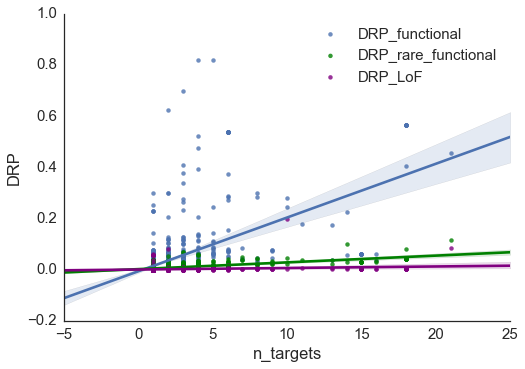

In [84]:
with sns.axes_style("white"):
    ax = sns.regplot(x="n_targets", y="DRP_functional", data=DRP_scores_all_drugs, label="DRP_functional")
    sns.regplot(x="n_targets", y="DRP_rare_functional", data=DRP_scores_all_drugs,
                ax=ax, color="green", label="DRP_rare_functional")
    sns.regplot(x="n_targets", y="DRP_LoF", data=DRP_scores_all_drugs, ax=ax, color="purple", label="DRP_LoF")
    ax.set_ylabel("DRP")
    ax.legend()
    sns.despine()

In [85]:
print model.summary()

                            OLS Regression Results                            
Dep. Variable:         DRP_functional   R-squared:                       0.282
Model:                            OLS   Adj. R-squared:                  0.281
Method:                 Least Squares   F-statistic:                     487.1
Date:                Mon, 18 Dec 2017   Prob (F-statistic):           2.64e-91
Time:                        23:33:18   Log-Likelihood:                 1379.0
No. Observations:                1242   AIC:                            -2754.
Df Residuals:                    1240   BIC:                            -2744.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -0.0068      0.003     -2.245      0.0

In [86]:
print model_rare.summary()

                             OLS Regression Results                            
Dep. Variable:     DRP_rare_functional   R-squared:                       0.387
Model:                             OLS   Adj. R-squared:                  0.386
Method:                  Least Squares   F-statistic:                     781.7
Date:                 Mon, 18 Dec 2017   Prob (F-statistic):          8.79e-134
Time:                         23:33:18   Log-Likelihood:                 4250.3
No. Observations:                 1242   AIC:                            -8497.
Df Residuals:                     1240   BIC:                            -8486.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.0018      0.000      5.89

In [87]:
print model_hc.summary()

                            OLS Regression Results                            
Dep. Variable:                DRP_LoF   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     40.11
Date:                Mon, 18 Dec 2017   Prob (F-statistic):           3.42e-10
Time:                        23:33:18   Log-Likelihood:                 4012.8
No. Observations:                1171   AIC:                            -8022.
Df Residuals:                    1169   BIC:                            -8011.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.0001      0.000      0.477      0.6

In [88]:
DRP_scores_all_drugs["DRP_functional_pred"] = model.predict()
DRP_scores_all_drugs["RMSE_functional"] = (DRP_scores_all_drugs["DRP_functional"] - DRP_scores_all_drugs["DRP_functional_pred"]) ** 2
DRP_scores_all_drugs["DRP_rare_functional_pred"] = model_rare.predict()
DRP_scores_all_drugs["RMSE_rare_functional"] = (DRP_scores_all_drugs["DRP_rare_functional"] - DRP_scores_all_drugs["DRP_rare_functional_pred"]) ** 2

#### Drugs with highest outlier DRP_functional score

In [89]:
DRP_scores_all_drugs.sort_values(by=["RMSE_functional"], ascending=False).head()

,name,midrug_id,n_targets,targets,n_functional_variants,DRP_functional,DRP_rare_functional,DRP_LoF,top100_units_Rank_top,top100_units_Rank_all,top100_sales_Rank_top,top100_sales_Rank_all,essential_medicines,DRP_functional_pred,RMSE_functional,DRP_rare_functional_pred,RMSE_rare_functional
1,Docetaxel,1236,4,"MAP2, MAPT, MAP4, TUBB1",606,0.817620,0.034910,0.002040,NaN,NaN,NaN,NaN,True,0.077278,0.548106,0.012329,0.000510
0,Paclitaxel,1217,5,"MAP2, BCL2, MAPT, MAP4, TUBB1",621,0.817679,0.035221,0.002074,NaN,NaN,NaN,NaN,True,0.098302,0.517504,0.014967,0.000410
2,Quinacrine,1091,3,"PLA2G6, PLA2G4A, PLCL1",232,0.698283,0.010971,0.001064,NaN,NaN,NaN,NaN,False,0.056255,0.412200,0.009690,0.000002
3,Azelaic Acid,538,2,"AKR1D1, TYR",211,0.625447,0.010118,0.002099,NaN,NaN,NaN,NaN,False,0.035231,0.348354,0.007051,0.000009
25,Acarbose,277,4,"SI, MGAM, GAA, AMY2A",865,0.520899,0.056443,0.009443,NaN,NaN,NaN,NaN,False,0.077278,0.196799,0.012329,0.001946


#### How many with RMSE above 0.01

In [90]:
len(DRP_scores_all_drugs.loc[DRP_scores_all_drugs.RMSE_functional > 0.01]), len(DRP_scores_all_drugs)

(77, 1242)

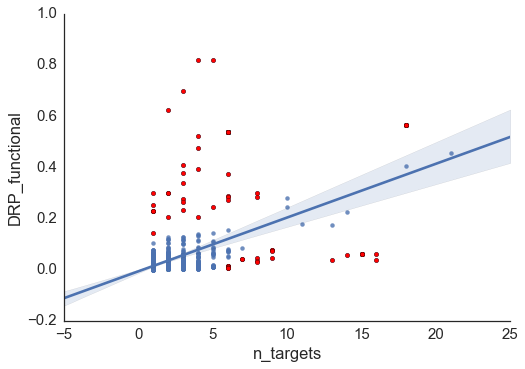

In [91]:
with sns.axes_style("white"):
    ax = sns.regplot(x="n_targets", y="DRP_functional", data=DRP_scores_all_drugs, label="DRP_functional")
    DRP_scores_all_drugs.loc[DRP_scores_all_drugs.RMSE_functional > 0.01].plot('n_targets', 'DRP_functional', ax=ax,
                                                                           kind='scatter', color='red')
    sns.despine()

#### Drugs with highest outlier DRP_rare_functional score

In [92]:
DRP_scores_all_drugs.sort_values(by=["RMSE_rare_functional"], ascending=False).head()

,name,midrug_id,n_targets,targets,n_functional_variants,DRP_functional,DRP_rare_functional,DRP_LoF,top100_units_Rank_top,top100_units_Rank_all,top100_sales_Rank_top,top100_sales_Rank_all,essential_medicines,DRP_functional_pred,RMSE_functional,DRP_rare_functional_pred,RMSE_rare_functional
52,Zonisamide,899,14,"CACNA1H, SCN11A, SCN4B, CACNA1I, CACNA1G, SCN9A, SCN2B, SCN2A, SCN1B, SCN1A, SCN4A, SCN5A, SCN3A, SCN3B",1958,0.224148,0.101226,0.004261,NaN,NaN,NaN,NaN,False,0.287513,0.004015,0.038715,0.003908
71,Lidocaine,274,3,"SCN5A, SCN10A, SCN9A",891,0.114055,0.068843,0.002702,43.0,"74, 43",NaN,NaN,True,0.056255,0.003341,0.009690,0.003499
72,Lidocaine,274,3,"SCN5A, SCN10A, SCN9A",891,0.114055,0.068843,0.002702,NaN,NaN,49.0,49.0,True,0.056255,0.003341,0.009690,0.003499
27,Marimastat,776,21,"MMP14, MMP15, MMP24, MMP17, MMP10, MMP11, MMP16, MMP13, MMP21, MMP19, MMP3, MMP28, MMP8, MMP9, MMP25, MMP7, MMP27, MMP26, MMP2, MMP20, MMP1",1769,0.455667,0.115343,0.082606,NaN,NaN,NaN,NaN,False,0.434676,0.000441,0.057185,0.003382
53,Miglitol,483,4,"GANC, MGAM, GANAB, GAA",807,0.205631,0.060314,0.010757,NaN,NaN,NaN,NaN,False,0.077278,0.016474,0.012329,0.002303


# Compare CAP score between different populations

## Create supplemental tables

In [93]:
include_cols = [('SYMBOL', ''), ('group'), ('subgroup'), ('var_uid', 'n_deleterious_variants'),
                ('P_min_one_LoF', 'risk_difference'), ('P_min_one_LoF', 'log_risk_ratio'),
                ('P_min_one_LoF', 'pop'), ('P_min_one_LoF', 'min pop')
               ] + [("COMP.AF_" + p, "P_min_one_LoF") for p in ['Adj'] + POPS]
new_col_names = ['symbol', 'group', 'subgroup', 'n_variants', 'risk_difference', 'log_risk_ratio',
                 'max_risk_population', 'min_risk_population'
                ] + ['CAP_' + p for p in ['Adj'] + POPS]

prob_lof_all_pharmacogenes_pop = pharmacogenes_subset[include_cols]
prob_lof_all_pharmacogenes_pop.columns = new_col_names
prob_lof_all_pharmacogenes_pop.sort_values(by=["risk_difference"], inplace=True, ascending=False)

prob_lof_rare_all_pharmacogenes_pop = pharmacogenes_subset_rare[include_cols]
prob_lof_rare_all_pharmacogenes_pop.columns = [x if not x.startswith('CAP') else x + '_rare' for x in new_col_names]
prob_lof_rare_all_pharmacogenes_pop.sort_values(by=["risk_difference"], inplace=True, ascending=False)

lof_all_pharmacogenes_pop = pharmacogenes_subset_lof[include_cols]
lof_all_pharmacogenes_pop.columns = [x if not x.startswith('CAP') else x + '_LoF' for x in new_col_names]
lof_all_pharmacogenes_pop.sort_values(by=["risk_difference"], inplace=True, ascending=False)

/Users/schaerfe/Documents/Privat/Dropbox/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/schaerfe/Documents/Privat/Dropbox/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/schaerfe/Documents/Privat/Dropbox/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Export supplemenatry tables

In [94]:
prob_lof_all_pharmacogenes_pop.to_csv(SUPPLEMENT_PATH + "CAP_differences_across_populations_all_functional.txt",
                                      sep="\t", index=False)

In [95]:
prob_lof_rare_all_pharmacogenes_pop.to_csv(SUPPLEMENT_PATH + "CAP_differences_across_populations_rare_functional.txt",
                                      sep="\t", index=False)

In [96]:
lof_all_pharmacogenes_pop.to_csv(SUPPLEMENT_PATH + "CAP_differences_across_populations_LoF.txt",
                                      sep="\t", index=False)

## Genes with highest differences

### Highest risk difference

#### Functional

In [97]:
prob_lof_all_pharmacogenes_pop.head(25)

,symbol,group,subgroup,n_variants,risk_difference,log_risk_ratio,max_risk_population,min_risk_population,CAP_Adj,CAP_AFR,CAP_AMR,CAP_SAS,CAP_EAS,CAP_NFE,CAP_FIN
3,TYR,target,target,149,0.776613,4.605990,NFE,EAS,0.624359,0.211005,0.467059,0.304501,0.007838,0.784451,0.545254
15,MAP1A,target,cancer target,330,0.631898,1.334978,AFR,FIN,0.421974,0.857583,0.440301,0.424633,0.708187,0.310830,0.225685
18,PARP1,target,cancer target,110,0.594122,1.923189,AMR,AFR,0.367402,0.101685,0.695808,0.204004,0.685585,0.322548,0.419107
55,SLC28A1,ADME,transporter,143,0.565463,2.969707,EAS,FIN,0.123839,0.208028,0.052501,0.187484,0.596052,0.040282,0.030588
16,CD3G,target,cancer target,24,0.560995,1.423305,EAS,AMR,0.392043,0.293922,0.178048,0.702678,0.739043,0.297927,0.335157
36,VWF,target,target,347,0.527770,2.682474,AFR,EAS,0.228604,0.566516,0.213457,0.341329,0.038746,0.168996,0.151272
9,SULT1A2,ADME,phase II enzyme,76,0.515409,1.369796,FIN,EAS,0.535152,0.461931,0.633474,0.364891,0.175635,0.590009,0.691044
46,CYP3A43,ADME,CYP450,101,0.493954,4.337047,AFR,EAS,0.156026,0.500498,0.114180,0.114588,0.006544,0.136923,0.091646
19,UGT2B4,ADME,phase II enzyme,122,0.490109,3.564205,AMR,EAS,0.359546,0.338287,0.504394,0.182170,0.014284,0.413467,0.391499
111,ALDH2,target,target,99,0.463435,4.662681,EAS,NFE,0.053600,0.005425,0.057665,0.019014,0.467852,0.004417,0.004872


#### Highlighted in Kozyra

#### Functional rare

In [98]:
prob_lof_rare_all_pharmacogenes_pop.head(10)

,symbol,group,subgroup,n_variants,risk_difference,log_risk_ratio,max_risk_population,min_risk_population,CAP_Adj_rare,CAP_AFR_rare,CAP_AMR_rare,CAP_SAS_rare,CAP_EAS_rare,CAP_NFE_rare,CAP_FIN_rare
1,ABCB5,ADME,transporter,318,0.104961,1.998563,AFR,NFE,0.032380,0.121416,0.032443,0.030854,0.057285,0.016456,0.019177
6,VWF,target,target,340,0.079783,3.102351,AFR,FIN,0.023774,0.083537,0.016621,0.033890,0.032489,0.013839,0.003754
2,ACE,target,target,271,0.075192,1.751150,AFR,SAS,0.029123,0.090985,0.024076,0.015793,0.038786,0.022177,0.031294
13,KCNJ12,target,target,130,0.059937,2.640750,AFR,FIN,0.017976,0.064539,0.012905,0.027345,0.016310,0.010637,0.004602
43,SLC22A10,ADME,transporter,124,0.054403,5.197171,AFR,FIN,0.011714,0.054705,0.012117,0.012747,0.006974,0.006562,0.000303
0,SCN10A,target,target,409,0.051570,1.364331,SAS,FIN,0.037166,0.040039,0.035724,0.069272,0.042643,0.030373,0.017703
33,ABCC4,ADME,transporter,172,0.050077,3.518463,EAS,FIN,0.013523,0.028130,0.025522,0.007774,0.051606,0.006774,0.001530
24,CYP1A1,ADME,CYP450,150,0.049634,3.738907,EAS,FIN,0.014807,0.021222,0.014763,0.017380,0.050843,0.009859,0.001209
8,MAP1A,target,cancer target,325,0.043863,1.377741,FIN,NFE,0.022941,0.034183,0.018101,0.032149,0.033888,0.014789,0.058652
45,UGT2A1,ADME,phase II enzyme,142,0.042418,4.950785,AFR,FIN,0.011645,0.042720,0.008773,0.009106,0.012992,0.009004,0.000302


#### LoF

In [99]:
lof_all_pharmacogenes_pop.head(10)

,symbol,group,subgroup,n_variants,risk_difference,log_risk_ratio,max_risk_population,min_risk_population,CAP_Adj_LoF,CAP_AFR_LoF,CAP_AMR_LoF,CAP_SAS_LoF,CAP_EAS_LoF,CAP_NFE_LoF,CAP_FIN_LoF
4,ABCB5,ADME,transporter,69,0.748628,3.181351,EAS,NFE,0.220355,0.122855,0.579903,0.200559,0.781066,0.032437,0.192626
5,CYP3A43,ADME,CYP450,28,0.460728,5.975830,AFR,EAS,0.107417,0.461901,0.066035,0.105473,0.001173,0.073056,0.035631
8,EGF,target,target,35,0.449368,6.206508,EAS,FIN,0.082212,0.006233,0.004861,0.298807,0.450276,0.001836,0.000908
7,SLC22A14,ADME,transporter,23,0.404933,3.190274,EAS,AFR,0.087719,0.017383,0.057165,0.079372,0.422316,0.063652,0.038566
0,CYP2F1,ADME,CYP450,18,0.378139,0.913883,AFR,AMR,0.384055,0.631247,0.253107,0.414603,0.437109,0.343569,0.413265
2,GSTT2,ADME,phase II enzyme,1,0.340200,1.113910,EAS,AMR,0.268632,0.168716,0.166256,0.255425,0.506455,0.274011,0.228143
1,CYP4B1,ADME,CYP450,23,0.327972,1.373114,EAS,AFR,0.274345,0.111267,0.342784,0.253548,0.439239,0.270058,0.264118
3,FCGR2A,target,target,9,0.251826,3.798944,NFE,EAS,0.195876,0.051749,0.109475,0.169575,0.005769,0.257595,0.219019
22,SULT1A1,ADME,phase II enzyme,19,0.209303,5.853592,EAS,FIN,0.018076,0.003267,0.014299,0.002181,0.209303,0.000601,0.000000
15,CYP3A5,ADME,CYP450,29,0.190799,3.063595,AFR,FIN,0.036022,0.200150,0.016539,0.012920,0.016826,0.023215,0.009351


### Highest risk ratio

#### Functional

In [100]:
prob_lof_all_pharmacogenes_pop.loc[prob_lof_all_pharmacogenes_pop.log_risk_ratio != np.inf]\
    .sort_values(by=["log_risk_ratio"], ascending=False)\
    .head(10)

,symbol,group,subgroup,n_variants,risk_difference,log_risk_ratio,max_risk_population,min_risk_population,CAP_Adj,CAP_AFR,CAP_AMR,CAP_SAS,CAP_EAS,CAP_NFE,CAP_FIN
188,SLC10A1,ADME,transporter,124,0.160786,6.268366,EAS,FIN,0.019085,0.013531,0.016632,0.008862,0.161091,0.005343,0.000305
127,ABCB11,ADME,transporter,189,0.218696,5.892812,SAS,FIN,0.038264,0.015678,0.009844,0.219302,0.008836,0.006529,0.000605
273,IL11RA,target,cancer target,76,0.103565,5.836821,EAS,FIN,0.010260,0.003882,0.003551,0.004720,0.103868,0.002227,0.000303
289,CCKAR,target,target,86,0.064681,5.370255,AFR,FIN,0.009342,0.064984,0.006395,0.011524,0.000693,0.002500,0.000302
220,FGA,target,target,118,0.064047,5.360442,SAS,FIN,0.014276,0.014535,0.004319,0.064349,0.012876,0.004972,0.000302
408,TNFSF11,target,cancer target,18,0.042575,5.173804,AFR,SAS,0.004493,0.042818,0.003281,0.000242,0.000924,0.000629,0.000303
104,ADH1B,target,target,66,0.364713,5.155747,AFR,FIN,0.049647,0.366828,0.030733,0.017203,0.006226,0.015636,0.002115
185,MMP7,target,target,67,0.197228,5.096224,EAS,FIN,0.019817,0.009406,0.005861,0.016856,0.198443,0.002077,0.001214
114,SLC28A2,ADME,transporter,117,0.288876,5.077192,AMR,FIN,0.043314,0.012248,0.290689,0.013419,0.091577,0.007160,0.001813
191,CD4,target,target,49,0.141928,5.059048,AFR,FIN,0.018629,0.142836,0.012404,0.002693,0.022807,0.004824,0.000907


#### Functional rare

In [101]:
prob_lof_rare_all_pharmacogenes_pop.loc[prob_lof_rare_all_pharmacogenes_pop.log_risk_ratio != np.inf]\
    .sort_values(by=["log_risk_ratio"], ascending=False)\
    .head(10)

,symbol,group,subgroup,n_variants,risk_difference,log_risk_ratio,max_risk_population,min_risk_population,CAP_Adj_rare,CAP_AFR_rare,CAP_AMR_rare,CAP_SAS_rare,CAP_EAS_rare,CAP_NFE_rare,CAP_FIN_rare
43,SLC22A10,ADME,transporter,124,0.054403,5.197171,AFR,FIN,0.011714,0.054705,0.012117,0.012747,0.006974,0.006562,0.000303
45,UGT2A1,ADME,phase II enzyme,142,0.042418,4.950785,AFR,FIN,0.011645,0.042720,0.008773,0.009106,0.012992,0.009004,0.000302
733,FCGR1A,target,target,5,0.003514,4.764395,SAS,AFR,0.000540,0.000000,0.000000,0.003514,0.000521,0.000030,0.000000
591,TNFSF13B,target,cancer target,5,0.014815,4.575012,AFR,EAS,0.001449,0.014815,0.001044,0.000000,0.000000,0.000153,0.000000
82,CYP4F12,ADME,CYP450,133,0.025557,4.448780,AFR,FIN,0.009205,0.025859,0.019068,0.008856,0.022939,0.004054,0.000302
86,ERBB2,target,cancer target,125,0.025186,4.434358,AFR,FIN,0.009081,0.025489,0.012611,0.014078,0.003234,0.006287,0.000302
409,IL17A,target,cancer target,17,0.020051,4.428158,AMR,SAS,0.003083,0.001153,0.020293,0.000242,0.004662,0.001170,0.000605
315,CYP21A2,ADME,CYP450,26,0.024567,4.409144,EAS,FIN,0.006141,0.001455,0.002942,0.006485,0.024869,0.005423,0.000303
230,ITGB3,target,target,100,0.022743,4.332980,AFR,FIN,0.005498,0.023045,0.005533,0.003395,0.011517,0.002968,0.000303
415,CD4,target,target,47,0.022504,4.321955,EAS,FIN,0.003095,0.001792,0.003646,0.001238,0.022807,0.001380,0.000303


## Overlap of genes with CAP > 1% between populations

In [102]:
def calculate_population_overlap2(scores,
                                 populations=POPS,
                                 adjusted_counts="Adj",
                                 col_prefix='CAP_',
                                 threshold=0.01,
                                 entity_col='symbol'):
    """Note that if pseudocounts are added some data sets always have at least one observation added to each population"""
    
    overall_above_thresh = scores.loc[scores[col_prefix + adjusted_counts] > threshold]
    print "{} {}s above {} threshold ({}) in total population".format(len(overall_above_thresh), entity_col,
                                                                      col_prefix.replace("_", ""),
                                                                     threshold)
    pop_above_thresh = {}
    for p in sorted(populations):
        pop_above_thresh[p] = scores.loc[scores[col_prefix + p] > threshold]
        print "{} genes above CAP threshold ({}) in {}".format(len(pop_above_thresh[p]), threshold, p)
    
    i_pop = sorted(pop_above_thresh.items())
    overlap = np.zeros((len(i_pop), len(i_pop)))

    for i, (p, g) in enumerate(i_pop[:-1]):
        overlap[i, i] = len(set(g[entity_col].tolist()))
        all_others = []
        for j, (q, h) in enumerate(i_pop[i + 1:]):
            print 'overlap', p, q, len(set(g[entity_col].tolist()) & set(h[entity_col].tolist()))
            overlap[i, i+j+1] = len(set(g[entity_col].tolist()) & set(h[entity_col].tolist()))
            overlap[i+j+1, i] = len(set(g[entity_col].tolist()) & set(h[entity_col].tolist()))
        

    # handle last population
    overlap[len(i_pop) - 1, len(i_pop) - 1] = len(set(pop_above_thresh[i_pop[-1][0]][entity_col].tolist()))
    
    # calculate number of unique snps in each population
    unique = {}
    for (p, g) in pop_above_thresh.items():
        all_others = [set(h[entity_col].tolist()) for q, h in pop_above_thresh.items() if q != p]
        u = set(g[entity_col].tolist()) - set.union(*all_others)
        a = set(g[entity_col].tolist())
        unique[p] = (len(u) / float(len(a)), len(u))
    
    print len(set.intersection(*[set(y[entity_col].tolist()) for (x, y) in i_pop])),\
        "genes above CAP threshold ({}) overlap in all populations.".format(threshold)
    
    cols = [x for (x, y) in i_pop]
    return overlap, cols, unique

In [103]:
cap_overlap_matrix, labels, unique_high_cap = calculate_population_overlap2(prob_lof_all_pharmacogenes_pop,
                                                                            threshold=0.01)

276 symbols above CAP threshold (0.01) in total population
296 genes above CAP threshold (0.01) in AFR
241 genes above CAP threshold (0.01) in AMR
233 genes above CAP threshold (0.01) in EAS
199 genes above CAP threshold (0.01) in FIN
229 genes above CAP threshold (0.01) in NFE
266 genes above CAP threshold (0.01) in SAS
overlap AFR AMR 205
overlap AFR EAS 177
overlap AFR FIN 163
overlap AFR NFE 193
overlap AFR SAS 206
overlap AMR EAS 160
overlap AMR FIN 165
overlap AMR NFE 192
overlap AMR SAS 191
overlap EAS FIN 126
overlap EAS NFE 147
overlap EAS SAS 170
overlap FIN NFE 175
overlap FIN SAS 163
overlap NFE SAS 189
113 genes above CAP threshold (0.01) overlap in all populations.


In [104]:
import pyupset as pyu

In [105]:
def calculate_population_drugs(scores,
                               populations=POPS,
                               adjusted_counts="Adj",
                               col_prefix='CAP_',
                               threshold=0.01,
                               entity_col='symbol'):
    
    overall_above_thresh = scores.loc[scores[col_prefix + adjusted_counts] > threshold]
    print "{} {}s above {} threshold ({}) in total population".format(len(overall_above_thresh), entity_col,
                                                                      col_prefix.replace("_", ""),
                                                                      threshold)
    pop_above_thresh = {}
    for p in sorted(populations):
        pop_above_thresh[p] = scores.loc[scores[col_prefix + p] > threshold]
        print "{} genes above {} threshold ({}) in {}".format(len(pop_above_thresh[p]),
                                                              col_prefix.replace("_", ""),
                                                              threshold, p)
    return pop_above_thresh

In [106]:
pop_above_thresh = calculate_population_drugs(prob_lof_all_pharmacogenes_pop, threshold=0.01)

276 symbols above CAP threshold (0.01) in total population
296 genes above CAP threshold (0.01) in AFR
241 genes above CAP threshold (0.01) in AMR
233 genes above CAP threshold (0.01) in EAS
199 genes above CAP threshold (0.01) in FIN
229 genes above CAP threshold (0.01) in NFE
266 genes above CAP threshold (0.01) in SAS


In [107]:
# pop_above_thresh = calculate_population_drugs(prob_lof_all_pharmacogenes_pop, threshold=0.01,
#                                               col_prefix='CAP_', entity_col='symbol')
# pyu.plot(pop_above_thresh, sort_by='degree')

/Users/schaerfe/Documents/Privat/Dropbox/anaconda/lib/python2.7/site-packages/seaborn/matrix.py:143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if xticklabels == []:
/Users/schaerfe/Documents/Privat/Dropbox/anaconda/lib/python2.7/site-packages/seaborn/matrix.py:151: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if yticklabels == []:


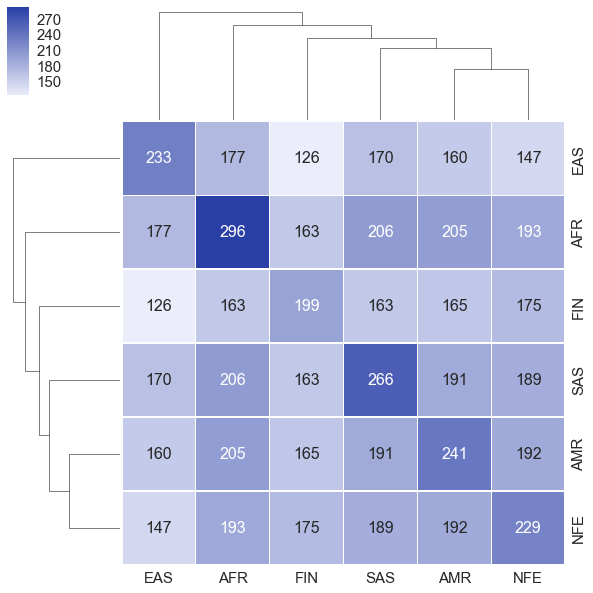

In [108]:
cmap = sns.light_palette("#2A3FA6", as_cmap=True)
ax = sns.clustermap(cap_overlap_matrix, linewidths=.5,
                    xticklabels=labels, yticklabels=labels,
                    annot=True, fmt=".0f",
                    cmap=cmap, annot_kws={"size":16})
plt.savefig(RAW_FIGURE_PATH + "shared_high_cap_matrix.pdf",
            dpi=300)

# Compare DRP score between different populations

## Create supplemental tables

In [109]:
populations = ['AFR', 'AMR', 'EAS', 'FIN', 'NFE', 'SAS']
p_col_temp = ("COMP.AF_{}", "P_no_LoF", "P_var_in_any")
p_cols = [tuple([s.format(p) for s in p_col_temp]) for p in POPS]

### Functional

In [110]:
drugs_AF_lof.loc[:, ('P_no_LoF', 'P_var_in_any', 'max_pop',)] = drugs_AF_lof.apply(
        tools.find_pop2,
        axis=1,
        args=(('P_no_LoF', 'P_var_in_any', 'max'), p_cols))
drugs_AF_lof.loc[:, ('P_no_LoF', 'P_var_in_any', 'max_pop',)] = drugs_AF_lof.loc[:, ('P_no_LoF', 'P_var_in_any', 'max_pop')].\
        apply(lambda x: x.replace("COMP.AF_", ''))
drugs_AF_lof.loc[:, ('P_no_LoF', 'P_var_in_any', 'min_pop',)] = drugs_AF_lof.apply(
        tools.find_pop2,
        axis=1,
        args=(('P_no_LoF', 'P_var_in_any', 'min'), p_cols))
drugs_AF_lof.loc[:, ('P_no_LoF', 'P_var_in_any', 'min_pop',)] = drugs_AF_lof.loc[:, ('P_no_LoF', 'P_var_in_any', 'min_pop')].\
        apply(lambda x: x.replace("COMP.AF_", ''))

In [111]:
include_cols = [("SYMBOL", "", "n_targets"), ("SYMBOL", "", "targets"),
                ("var_uid", "n_deleterious_variants", "n_variants"),
                ('P_no_LoF', 'P_var_in_any', 'max_pop'),
                ('P_no_LoF', 'P_var_in_any', 'min_pop'),
                ("P_no_LoF", "P_var_in_any", "risk_difference"),
                ("P_no_LoF", "P_var_in_any", "log_risk_ratio"),
                ("COMP.AF_Adj", "P_no_LoF", "P_var_in_any")
                ] + [("COMP.AF_" + p, "P_no_LoF", "P_var_in_any") for p in POPS]
prob_lof_all_DRP_pop = drugs_AF_lof[include_cols]
new_col_names = ["n_targets", "targets", "n_variants", "max_pop", "min_pop",
                 "DRP_difference", "DRP_log_risk_ratio"] +\
                ["DRP_" + p for p in ["Adj"] + POPS]
prob_lof_all_DRP_pop.columns = new_col_names
prob_lof_all_DRP_pop = prob_lof_all_DRP_pop.reset_index()
prob_lof_all_DRP_pop.sort_values(by="DRP_difference", ascending=False, inplace=True)

In [112]:
prob_lof_all_DRP_pop = prob_lof_all_DRP_pop.merge(top_100_drugs[['midrug_id',
                                                                 'top100_units_Rank_top',
                                                                 'top100_units_Rank_all',
                                                                 'top100_sales_Rank_top',
                                                                 'top100_sales_Rank_all']],
                                                  on='midrug_id', how='left')
prob_lof_all_DRP_pop["essential_medicines"] = DRP_scores_all_drugs["midrug_id"].isin(essential_compounds)
prob_lof_all_DRP_pop.to_csv(SUPPLEMENT_PATH + "functional_DRP_all_drugs_pop_differences.txt",
                            sep="\t", index=False, float_format='%.5f')

### Rare functional

In [113]:
drugs_AF_lof_rare.loc[:, ('P_no_LoF', 'P_var_in_any', 'max_pop',)] = drugs_AF_lof_rare.apply(
        tools.find_pop2,
        axis=1,
        args=(('P_no_LoF', 'P_var_in_any', 'max'), p_cols))
drugs_AF_lof_rare.loc[:, ('P_no_LoF', 'P_var_in_any', 'max_pop',)] = drugs_AF_lof_rare.loc[:, ('P_no_LoF', 'P_var_in_any', 'max_pop')].\
        apply(lambda x: x.replace("COMP.AF_", ''))
drugs_AF_lof_rare.loc[:, ('P_no_LoF', 'P_var_in_any', 'min_pop',)] = drugs_AF_lof_rare.apply(
        tools.find_pop2,
        axis=1,
        args=(('P_no_LoF', 'P_var_in_any', 'min'), p_cols))
drugs_AF_lof_rare.loc[:, ('P_no_LoF', 'P_var_in_any', 'min_pop',)] = drugs_AF_lof_rare.loc[:, ('P_no_LoF', 'P_var_in_any', 'min_pop')].\
        apply(lambda x: x.replace("COMP.AF_", ''))

In [114]:
prob_lof_rare_all_DRP_pop = drugs_AF_lof_rare[include_cols]
new_col_names = ["n_targets", "targets", "n_variants", "max_pop", "min_pop",
                 "DRP_difference", "DRP_log_risk_ratio"] +\
                ["DRP_" + p + "_rare" for p in ["Adj"] + POPS]
prob_lof_rare_all_DRP_pop.columns = new_col_names
prob_lof_rare_all_DRP_pop= prob_lof_rare_all_DRP_pop.reset_index()
prob_lof_rare_all_DRP_pop.sort_values(by="DRP_difference", ascending=False, inplace=True)

In [115]:
prob_lof_rare_all_DRP_pop = prob_lof_rare_all_DRP_pop.merge(top_100_drugs[['midrug_id',
                                                                 'top100_units_Rank_top',
                                                                 'top100_units_Rank_all',
                                                                 'top100_sales_Rank_top',
                                                                 'top100_sales_Rank_all']],
                                                  on='midrug_id', how='left')
prob_lof_rare_all_DRP_pop["essential_medicines"] = prob_lof_rare_all_DRP_pop["midrug_id"].isin(essential_compounds)
prob_lof_rare_all_DRP_pop.to_csv(SUPPLEMENT_PATH + "rare_functional_DRP_all_drugs_pop_differences.txt",
                                 sep="\t", index=False, float_format='%.5f')

### LoF

In [116]:
drugs_AF_lof_hc.loc[:, ('P_no_LoF', 'P_var_in_any', 'max_pop',)] = drugs_AF_lof_hc.apply(
        tools.find_pop2,
        axis=1,
        args=(('P_no_LoF', 'P_var_in_any', 'max'), p_cols))
drugs_AF_lof_hc.loc[:, ('P_no_LoF', 'P_var_in_any', 'max_pop',)] = drugs_AF_lof_hc.loc[:, ('P_no_LoF', 'P_var_in_any', 'max_pop')].\
        apply(lambda x: x.replace("COMP.AF_", ''))
drugs_AF_lof_hc.loc[:, ('P_no_LoF', 'P_var_in_any', 'min_pop',)] = drugs_AF_lof_hc.apply(
        tools.find_pop2,
        axis=1,
        args=(('P_no_LoF', 'P_var_in_any', 'min'), p_cols))
drugs_AF_lof_hc.loc[:, ('P_no_LoF', 'P_var_in_any', 'min_pop',)] = drugs_AF_lof_hc.loc[:, ('P_no_LoF', 'P_var_in_any', 'min_pop')].\
        apply(lambda x: x.replace("COMP.AF_", ''))

In [117]:
include_cols = [("SYMBOL", "", "n_targets"), ("SYMBOL", "", "targets"),
                ("var_uid", "n_deleterious_variants", "n_variants"),
                ('P_no_LoF', 'P_var_in_any', 'max_pop'),
                ('P_no_LoF', 'P_var_in_any', 'min_pop'),
                ("P_no_LoF", "P_var_in_any", "risk_difference"),
                ("P_no_LoF", "P_var_in_any", "log_risk_ratio"),
                ("COMP.AF_Adj_hc", "P_no_LoF", "P_var_in_any")
                ] + [("COMP.AF_" + p, "P_no_LoF", "P_var_in_any") for p in POPS]
lof_all_DRP_pop = drugs_AF_lof_hc[include_cols]
new_col_names = ["n_targets", "targets", "n_variants", "max_pop", "min_pop",
                 "DRP_difference", "DRP_log_risk_ratio"] +\
                ["DRP_" + p + "_LoF" for p in ["Adj"] + POPS]
lof_all_DRP_pop.columns = new_col_names
lof_all_DRP_pop = lof_all_DRP_pop.reset_index()
lof_all_DRP_pop.sort_values(by="DRP_difference", ascending=False, inplace=True)

In [118]:
lof_all_DRP_pop = lof_all_DRP_pop.merge(top_100_drugs[['midrug_id',
                                                       'top100_units_Rank_top',
                                                       'top100_units_Rank_all',
                                                       'top100_sales_Rank_top',
                                                       'top100_sales_Rank_all']],
                                                  on='midrug_id', how='left')
lof_all_DRP_pop["essential_medicines"] = lof_all_DRP_pop["midrug_id"].isin(essential_compounds)
lof_all_DRP_pop.to_csv(SUPPLEMENT_PATH + "LoF_DRP_all_drugs_pop_differences.txt",
                       sep="\t", index=False, float_format='%.5f')

## Drugs with highest differences

In [119]:
prob_lof_all_DRP_pop.head()

,name,midrug_id,n_targets,targets,n_variants,max_pop,min_pop,DRP_difference,DRP_log_risk_ratio,DRP_Adj,DRP_AFR,DRP_AMR,DRP_SAS,DRP_EAS,DRP_NFE,DRP_FIN,top100_units_Rank_top,top100_units_Rank_all,top100_sales_Rank_top,top100_sales_Rank_all,essential_medicines
0,Azelaic Acid,538,2,"AKR1D1, TYR",211,NFE,EAS,0.772306,4.128110,0.625447,0.213748,0.469557,0.305745,0.012648,0.784954,0.547335,NaN,NaN,NaN,NaN,True
1,Muromonab,74,4,"CD247, CD3D, CD3E, CD3G",109,EAS,AMR,0.558436,1.404765,0.394345,0.296138,0.181631,0.704752,0.740066,0.299936,0.338413,NaN,NaN,NaN,NaN,True
2,Estramustine,1184,4,"MAP2, MAP1A, ESR2, ESR1",690,AFR,FIN,0.546769,0.995622,0.476289,0.867190,0.468708,0.465718,0.714385,0.391869,0.320421,NaN,NaN,NaN,NaN,False
3,Antihemophilic Factor (Recombinant),25,3,"F9, VWF, F10",425,AFR,EAS,0.530721,2.616581,0.231344,0.572547,0.216219,0.343125,0.041826,0.170757,0.152042,NaN,NaN,NaN,NaN,False
4,Olaparib,7823,3,"PARP1, PARP2, PARP3",330,AMR,AFR,0.464833,1.079078,0.409371,0.239362,0.704195,0.242421,0.692672,0.364859,0.502458,NaN,NaN,NaN,NaN,False


In [120]:
len(prob_lof_all_DRP_pop.loc[prob_lof_all_DRP_pop.DRP_difference > 0.3])

23

In [121]:
len(prob_lof_all_DRP_pop.loc[prob_lof_all_DRP_pop.DRP_difference > 0.1])

239

In [122]:
len(prob_lof_all_DRP_pop)

1242

### Top prescribed drugs in high diff set

In [123]:
len(prob_lof_all_DRP_pop.loc[(prob_lof_all_DRP_pop.DRP_difference > 0.3) &
                         (~prob_lof_all_DRP_pop.top100_units_Rank_top.isnull())])

1

In [124]:
len(prob_lof_all_DRP_pop.loc[(prob_lof_all_DRP_pop.DRP_difference > 0.1) &
                         (~prob_lof_all_DRP_pop.top100_units_Rank_top.isnull())])

11

In [125]:
prob_lof_all_DRP_pop.loc[(prob_lof_all_DRP_pop.DRP_difference > 0.1) &
                         (~prob_lof_all_DRP_pop.top100_units_Rank_top.isnull())]

,name,midrug_id,n_targets,targets,n_variants,max_pop,min_pop,DRP_difference,DRP_log_risk_ratio,DRP_Adj,DRP_AFR,DRP_AMR,DRP_SAS,DRP_EAS,DRP_NFE,DRP_FIN,top100_units_Rank_top,top100_units_Rank_all,top100_sales_Rank_top,top100_sales_Rank_all,essential_medicines
12,Omalizumab,42,2,"FCER1A, MS4A2",83,EAS,AMR,0.366656,2.207264,0.116511,0.328420,0.045318,0.117603,0.411974,0.055041,0.049309,82.0,82,79.0,79.0,False
36,Lidocaine,274,3,"SCN5A, SCN10A, SCN9A",891,AFR,NFE,0.236226,1.365384,0.114055,0.317203,0.091684,0.124786,0.123425,0.080976,0.116674,43.0,"74, 43",NaN,NaN,False
41,Oseltamivir,191,1,CES1,88,SAS,FIN,0.230746,1.714681,0.144214,0.195078,0.146058,0.281405,0.162022,0.106677,0.050659,37.0,37,92.0,92.0,False
79,Pemetrexed,632,4,"DHFR, TYMS, GART, ATIC",308,AFR,FIN,0.218375,3.480981,0.038137,0.225309,0.032210,0.014096,0.018347,0.019318,0.006934,93.0,93,41.0,41.0,False
123,Ezetimibe,963,2,"SOAT1, NPC1L1",315,AMR,SAS,0.139149,1.699330,0.061563,0.106944,0.170277,0.031128,0.035827,0.046923,0.055402,28.0,28,29.0,29.0,False
182,Epinephrine,658,6,"ADRA1A, ADRA1B, ADRA2A, ADRA2B, ADRB1, ADRB2",322,AMR,AFR,0.109796,1.550484,0.071321,0.029565,0.139361,0.084221,0.037272,0.066205,0.081269,90.0,90,NaN,NaN,False
186,Aripiprazole,1226,2,"HTR2A, DRD2",66,SAS,AFR,0.105988,2.172861,0.054123,0.013617,0.039333,0.119605,0.074066,0.044154,0.048839,23.0,23,1.0,1.0,False
194,Quetiapine,1212,2,"HTR2A, DRD2",66,SAS,AFR,0.105988,2.172861,0.054123,0.013617,0.039333,0.119605,0.074066,0.044154,0.048839,73.0,73,40.0,40.0,False
214,Memantine,1032,3,"GRIN3A, GRIN2B, GRIN2A",275,FIN,AFR,0.105610,1.545945,0.072268,0.028602,0.047983,0.030400,0.052590,0.089392,0.134212,29.0,29,26.0,26.0,False
219,Sitagliptin,1248,1,DPP4,130,FIN,EAS,0.105335,2.257798,0.061414,0.021315,0.034613,0.028623,0.012303,0.080825,0.117638,25.0,"25, 50",15.0,"62.0, 15.0",False


In [126]:
len(prob_lof_all_DRP_pop.loc[(prob_lof_all_DRP_pop.DRP_difference > 0.3) &
                         (prob_lof_all_DRP_pop.essential_medicines)])

3

In [127]:
len(prob_lof_all_DRP_pop.loc[(prob_lof_all_DRP_pop.DRP_difference > 0.1) &
                         (prob_lof_all_DRP_pop.essential_medicines)])

27

In [128]:
prob_lof_all_DRP_pop.loc[(prob_lof_all_DRP_pop.DRP_difference > 0.1) &
                         (prob_lof_all_DRP_pop.essential_medicines)]

,name,midrug_id,n_targets,targets,n_variants,max_pop,min_pop,DRP_difference,DRP_log_risk_ratio,DRP_Adj,DRP_AFR,DRP_AMR,DRP_SAS,DRP_EAS,DRP_NFE,DRP_FIN,top100_units_Rank_top,top100_units_Rank_all,top100_sales_Rank_top,top100_sales_Rank_all,essential_medicines
0,Azelaic Acid,538,2,"AKR1D1, TYR",211,NFE,EAS,0.772306,4.128110,0.625447,0.213748,0.469557,0.305745,0.012648,0.784954,0.547335,NaN,NaN,NaN,NaN,True
1,Muromonab,74,4,"CD247, CD3D, CD3E, CD3G",109,EAS,AMR,0.558436,1.404765,0.394345,0.296138,0.181631,0.704752,0.740066,0.299936,0.338413,NaN,NaN,NaN,NaN,True
6,Sucralfate,356,2,"EGF, FGF2",150,EAS,FIN,0.448309,4.638303,0.089722,0.013521,0.008136,0.308689,0.452689,0.010533,0.004379,NaN,NaN,NaN,NaN,True
58,Oxcarbazepine,766,1,SCN5A,246,AFR,NFE,0.222575,2.756984,0.038637,0.237663,0.037105,0.022898,0.020741,0.015088,0.022791,NaN,NaN,NaN,NaN,True
61,Aprindine,1376,1,SCN5A,246,AFR,NFE,0.222575,2.756984,0.038637,0.237663,0.037105,0.022898,0.020741,0.015088,0.022791,NaN,NaN,NaN,NaN,True
65,Amobarbital,1315,6,"GABRA5, GABRA4, GABRA6, GABRA1, GABRA3, GABRA2",205,EAS,SAS,0.218921,0.439406,0.536347,0.450155,0.475455,0.396751,0.615671,0.591891,0.400408,NaN,NaN,NaN,NaN,True
69,Primidone,784,6,"GABRA5, GABRA4, GABRA6, GABRA1, GABRA3, GABRA2",205,EAS,SAS,0.218921,0.439406,0.536347,0.450155,0.475455,0.396751,0.615671,0.591891,0.400408,NaN,NaN,NaN,NaN,True
71,Butalbital,234,6,"GABRA5, GABRA4, GABRA6, GABRA1, GABRA3, GABRA2",205,EAS,SAS,0.218921,0.439406,0.536347,0.450155,0.475455,0.396751,0.615671,0.591891,0.400408,NaN,NaN,NaN,NaN,True
72,Butethal,1317,6,"GABRA5, GABRA4, GABRA6, GABRA1, GABRA3, GABRA2",205,EAS,SAS,0.218921,0.439406,0.536347,0.450155,0.475455,0.396751,0.615671,0.591891,0.400408,NaN,NaN,NaN,NaN,True
86,Triazolam,887,18,"GABRB3, GABRG3, GABRR1, GABRR2, GABRG2, GABRQ, GABRP, GABRA5, GABRA3, GABRD, GABRE, GABRA4, GABRB2, GABRA6, GABRA1, GABRG1, GABRB1, GABRA2",781,EAS,SAS,0.217348,0.401677,0.563960,0.499735,0.491562,0.439682,0.657030,0.610591,0.461452,NaN,NaN,NaN,NaN,True


### Asthma meds

In [129]:
top_15_asthma_meds

['Budesonide',
 'Salbutamol',
 'Salmeterol',
 'Fluticasone Propionate',
 'Tiotropium']

In [130]:
prob_lof_all_DRP_pop.loc[prob_lof_all_DRP_pop.name.isin(top_15_asthma_meds)]

,name,midrug_id,n_targets,targets,n_variants,max_pop,min_pop,DRP_difference,DRP_log_risk_ratio,DRP_Adj,DRP_AFR,DRP_AMR,DRP_SAS,DRP_EAS,DRP_NFE,DRP_FIN,top100_units_Rank_top,top100_units_Rank_all,top100_sales_Rank_top,top100_sales_Rank_all,essential_medicines
608,Salmeterol,928,1,ADRB2,29,FIN,AFR,0.020416,3.990646,0.002539,0.000385,0.000519,0.001453,0.001852,0.001769,0.020801,6.0,6,6.0,6.0,False
610,Salbutamol,991,1,ADRB2,29,FIN,AFR,0.020416,3.990646,0.002539,0.000385,0.000519,0.001453,0.001852,0.001769,0.020801,3.0,"10, 3, 70, 71",NaN,NaN,False
611,Salbutamol,991,1,ADRB2,29,FIN,AFR,0.020416,3.990646,0.002539,0.000385,0.000519,0.001453,0.001852,0.001769,0.020801,NaN,NaN,44.0,"96.0, 100.0, 44.0",True
970,Budesonide,1210,1,NR3C1,49,SAS,FIN,0.003413,1.066841,0.001684,0.001174,0.001383,0.003413,0.001178,0.001588,0.000000,1.0,"1, 26",30.0,"57.0, 30.0",True
974,Fluticasone Propionate,578,1,NR3C1,49,SAS,FIN,0.003413,1.066841,0.001684,0.001174,0.001383,0.003413,0.001178,0.001588,0.000000,6.0,"32, 6",6.0,"52.0, 6.0",False
1073,Tiotropium,1357,1,CHRM3,21,EAS,AFR,0.002348,2.581668,0.000595,0.000192,0.000346,0.000242,0.002541,0.000572,0.000302,14.0,14,12.0,12.0,False


In [131]:
prob_lof_all_pharmacogenes_pop.loc[prob_lof_all_pharmacogenes_pop.symbol == 'ADRB2']

,symbol,group,subgroup,n_variants,risk_difference,log_risk_ratio,max_risk_population,min_risk_population,CAP_Adj,CAP_AFR,CAP_AMR,CAP_SAS,CAP_EAS,CAP_NFE,CAP_FIN
527,ADRB2,target,target,29,0.020416,3.990646,FIN,AFR,0.002539,0.000385,0.000519,0.001453,0.001852,0.001769,0.020801


## Difference in distribution

## Overlap of drugs between different populations

### All drugs

In [132]:
drp_overlap_matrix, labels, unique_high_drp = calculate_population_overlap2(prob_lof_all_DRP_pop, col_prefix="DRP_",
                                                                            threshold=0.01, entity_col="name")

530 names above DRP threshold (0.01) in total population
588 genes above CAP threshold (0.01) in AFR
522 genes above CAP threshold (0.01) in AMR
489 genes above CAP threshold (0.01) in EAS
473 genes above CAP threshold (0.01) in FIN
519 genes above CAP threshold (0.01) in NFE
531 genes above CAP threshold (0.01) in SAS
overlap AFR AMR 464
overlap AFR EAS 402
overlap AFR FIN 406
overlap AFR NFE 451
overlap AFR SAS 462
overlap AMR EAS 380
overlap AMR FIN 401
overlap AMR NFE 452
overlap AMR SAS 433
overlap EAS FIN 333
overlap EAS NFE 366
overlap EAS SAS 383
overlap FIN NFE 427
overlap FIN SAS 401
overlap NFE SAS 449
310 genes above CAP threshold (0.01) overlap in all populations.


530 names above DRP threshold (0.01) in total population
588 genes above DRP threshold (0.01) in AFR
522 genes above DRP threshold (0.01) in AMR
489 genes above DRP threshold (0.01) in EAS
473 genes above DRP threshold (0.01) in FIN
519 genes above DRP threshold (0.01) in NFE
531 genes above DRP threshold (0.01) in SAS


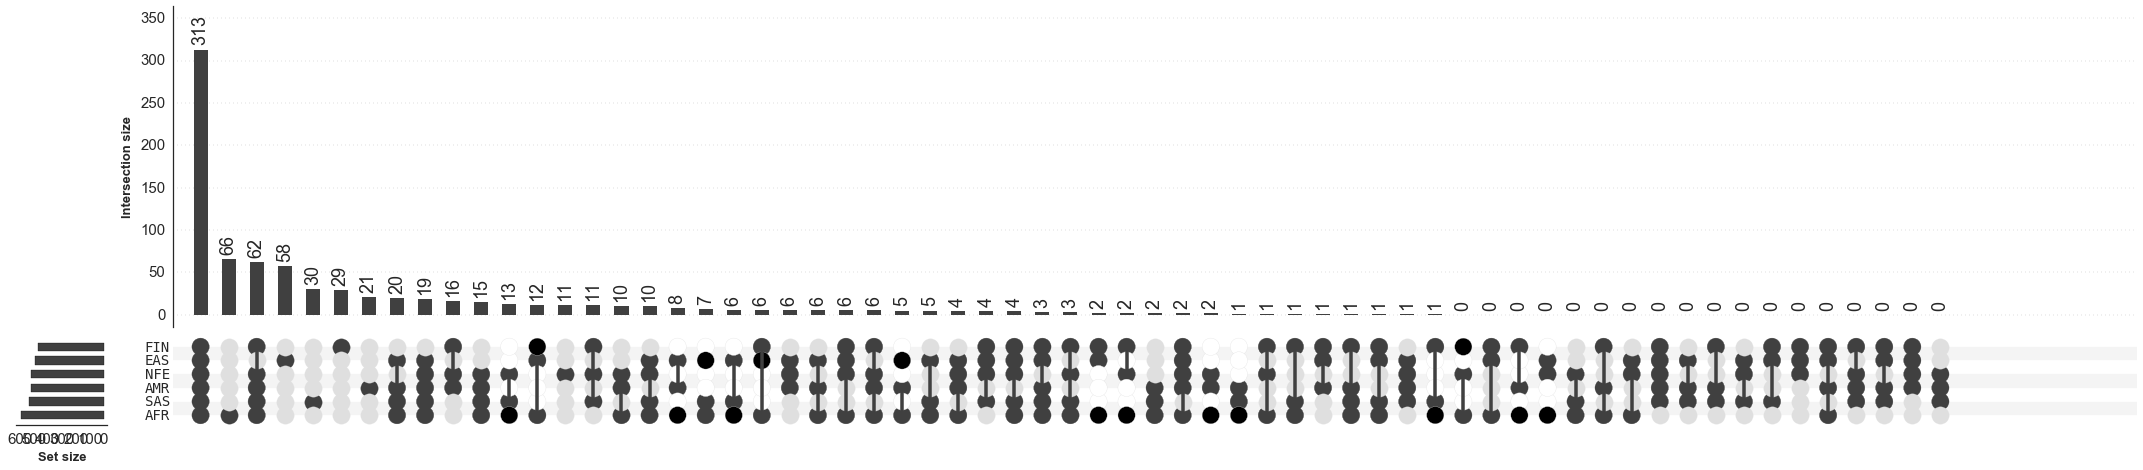

In [133]:
with sns.axes_style('white'):
    pop_drugs_above_thresh = calculate_population_drugs(prob_lof_all_DRP_pop, col_prefix="DRP_",
                                                  threshold=0.01, entity_col="name")
    for p in pop_drugs_above_thresh:
        pop_drugs_above_thresh[p] = pop_drugs_above_thresh[p][["name"]]
    props = pyu.plot(pop_drugs_above_thresh)
    props["figure"].set_size_inches(38, 7.5)

In [134]:
pop_drugs_above_thresh = calculate_population_drugs(prob_lof_all_DRP_pop, col_prefix="DRP_",
                                                    threshold=0.01, entity_col="name")
for p in POPS:
    pop_drugs_above_thresh[p][p] = 1
    pop_drugs_above_thresh[p] = pop_drugs_above_thresh[p][['name', p]]
    pop_drugs_above_thresh[p].drop_duplicates(inplace=True)
    print p, len(pop_drugs_above_thresh[p])

530 names above DRP threshold (0.01) in total population
588 genes above DRP threshold (0.01) in AFR
522 genes above DRP threshold (0.01) in AMR
489 genes above DRP threshold (0.01) in EAS
473 genes above DRP threshold (0.01) in FIN
519 genes above DRP threshold (0.01) in NFE
531 genes above DRP threshold (0.01) in SAS


/Users/schaerfe/Documents/Privat/Dropbox/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


AFR 586
AMR 520
SAS 527
EAS 488
NFE 515
FIN 471


In [135]:
merged = pop_drugs_above_thresh[POPS[0]][["name", POPS[0]]]
for p in POPS[1:]:
    print p, len(pop_drugs_above_thresh[p])
    merged = merged.merge(pop_drugs_above_thresh[p][["name", p]], how='outer', on="name")
merged.drop_duplicates(inplace=True)

AMR 520
SAS 527
EAS 488
NFE 515
FIN 471


In [136]:
merged.fillna(0.0).to_csv(SUPPLEMENT_PATH + "overlap_populations.csv", sep=';')

In R [replace supplement path with corresponding path]:
library(UpSetR)

drugs <- read.csv(SUPPLEMENT_PATH + "overlap_populations.csv", header=T, sep=';')

upset(drugs, mainbar.y.label="Shared drugs", sets.x.label="Drugs with high DRP", sets=c('NFE', 'FIN', 'SAS', 'EAS', 'AMR', 'AFR'), keep.order=TRUE, point.size=6, line.size=2.5, order.by="freq", mb.ratio=c(0.6, 0.4),  nintersects=15,
text.scale=2, queries=list(list(query=intersects, params=list("AFR"), color='#ffc300', active=T), list(query=intersects, params=list("AMR"), color="#870606", active=T), list(query=intersects, params=list("SAS"), color="#4f7a41", active=T), list(query=intersects, params=list("EAS"), color="#55973b", active=T), list(query=intersects, params=list("FIN"), color="#1d55da", active=T), list(query=intersects, params=list("NFE"), color="#426b94", active=T)))

In R [replace supplement path with corresponding path]:
> drugs <- read.csv(SUPPLEMENT_PATH + "overlap_populations.csv", header=T, sep=';')
> upset(drugs, mainbar.y.label="Shared drugs", sets.x.label="Drugs with high DRP", sets=c('NFE', 'FIN', 'SAS', 'EAS', 'AMR', 'AFR'), keep.order=TRUE, point.size=6, line.size=2.5, order.by="freq", mb.ratio=c(0.6, 0.4),  nintersects=15,
text.scale=2, queries=list(list(query=intersects, params=list("AFR"), color='#ffc300', active=T), list(query=intersects, params=list("AMR"), color="#870606", active=T), list(query=intersects, params=list("SAS"), color="#4f7a41", active=T), list(query=intersects, params=list("EAS"), color="#55973b", active=T), list(query=intersects, params=list("FIN"), color="#1d55da", active=T), list(query=intersects, params=list("NFE"), color="#426b94", active=T)))

In R [replace supplement path with corresponding path]:
> drugs <- read.csv(SUPPLEMENT_PATH + "overlap_populations.csv", header=T, sep=';')
> upset(drugs, mainbar.y.label="Shared drugs", sets.x.label="Drugs with high DRP", sets=c('NFE', 'FIN', 'SAS', 'EAS', 'AMR', 'AFR'), keep.order=TRUE, point.size=6, line.size=2.5, order.by="freq", mb.ratio=c(0.6, 0.4),  nintersects=15,
text.scale=2, queries=list(list(query=intersects, params=list("AFR"), color='#ffc300', active=T), list(query=intersects, params=list("AMR"), color="#870606", active=T), list(query=intersects, params=list("SAS"), color="#4f7a41", active=T), list(query=intersects, params=list("EAS"), color="#55973b", active=T), list(query=intersects, params=list("FIN"), color="#1d55da", active=T), list(query=intersects, params=list("NFE"), color="#426b94", active=T)))

In R [replace supplement path with corresponding path]:
> drugs <- read.csv(SUPPLEMENT_PATH + "overlap_populations.csv", header=T, sep=';')
> upset(drugs, mainbar.y.label="Shared drugs", sets.x.label="Drugs with high DRP", sets=c('NFE', 'FIN', 'SAS', 'EAS', 'AMR', 'AFR'), keep.order=TRUE, point.size=6, line.size=2.5, order.by="freq", mb.ratio=c(0.6, 0.4),  nintersects=15,
text.scale=2, queries=list(list(query=intersects, params=list("AFR"), color='#ffc300', active=T), list(query=intersects, params=list("AMR"), color="#870606", active=T), list(query=intersects, params=list("SAS"), color="#4f7a41", active=T), list(query=intersects, params=list("EAS"), color="#55973b", active=T), list(query=intersects, params=list("FIN"), color="#1d55da", active=T), list(query=intersects, params=list("NFE"), color="#426b94", active=T)))

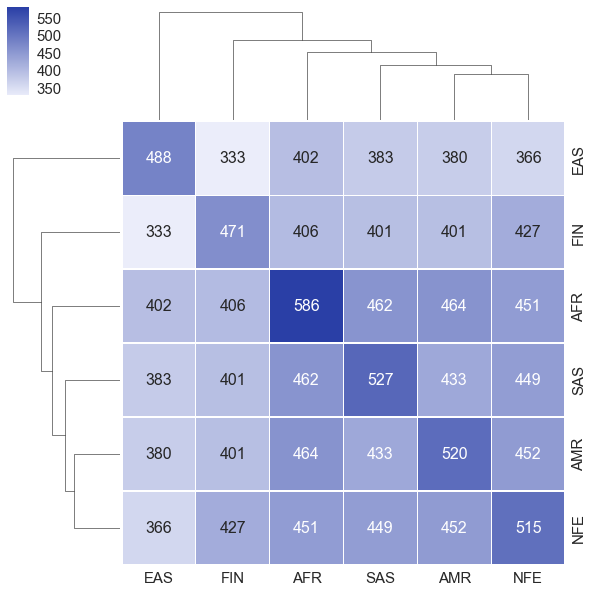

In [137]:
cmap = sns.light_palette("#2A3FA6", as_cmap=True)
ax = sns.clustermap(drp_overlap_matrix, linewidths=.5,
                    xticklabels=labels, yticklabels=labels,
                    annot=True, fmt=".0f",
                    cmap=cmap, annot_kws={"size":16})
plt.savefig(RAW_FIGURE_PATH + "shared_high_drp_matrix.pdf",
            dpi=300)

In [138]:
unique_high_drp

{'AFR': (0.11262798634812286, 66),
 'AMR': (0.04038461538461539, 21),
 'EAS': (0.11885245901639344, 58),
 'FIN': (0.059447983014861996, 28),
 'NFE': (0.021359223300970873, 11),
 'SAS': (0.056925996204933584, 30)}

In [139]:
drugs_AF_lof = drugs_AF_lof.reset_index()

In [140]:
print 'total', drugs_AF_lof['name'].nunique()
for p in ['Adj', 'AFR', 'AMR', 'EAS', 'SAS', 'FIN', 'NFE']:
    above_thresh = drugs_AF_lof.loc[
        drugs_AF_lof[("COMP.AF_" + p, "P_no_LoF", 'P_var_in_any')] >
        0.05]
    print p, above_thresh['name'].nunique()

total 1235
Adj 234
AFR 215
AMR 165
EAS 170
SAS 212
FIN 230
NFE 181


In [141]:
print 'total', drugs_AF_lof['name'].nunique()
for p in ['Adj', 'AFR', 'AMR', 'EAS', 'SAS', 'FIN', 'NFE']:
    above_thresh = drugs_AF_lof.loc[
        drugs_AF_lof[("COMP.AF_" + p, "P_no_LoF", 'P_var_in_any')] >
        0.01]
    print p, above_thresh['name'].nunique()

total 1235
Adj 528
AFR 586
AMR 520
EAS 488
SAS 527
FIN 471
NFE 515


#### Plot highest and lowest risk drugs for each population

In [142]:
interesting_subset = drugs_AF_lof.sort_values(by=('P_no_LoF', 'P_var_in_any', 'risk_difference'), ascending=False)
test = tools.calculate_mean_pop_difference(interesting_subset)

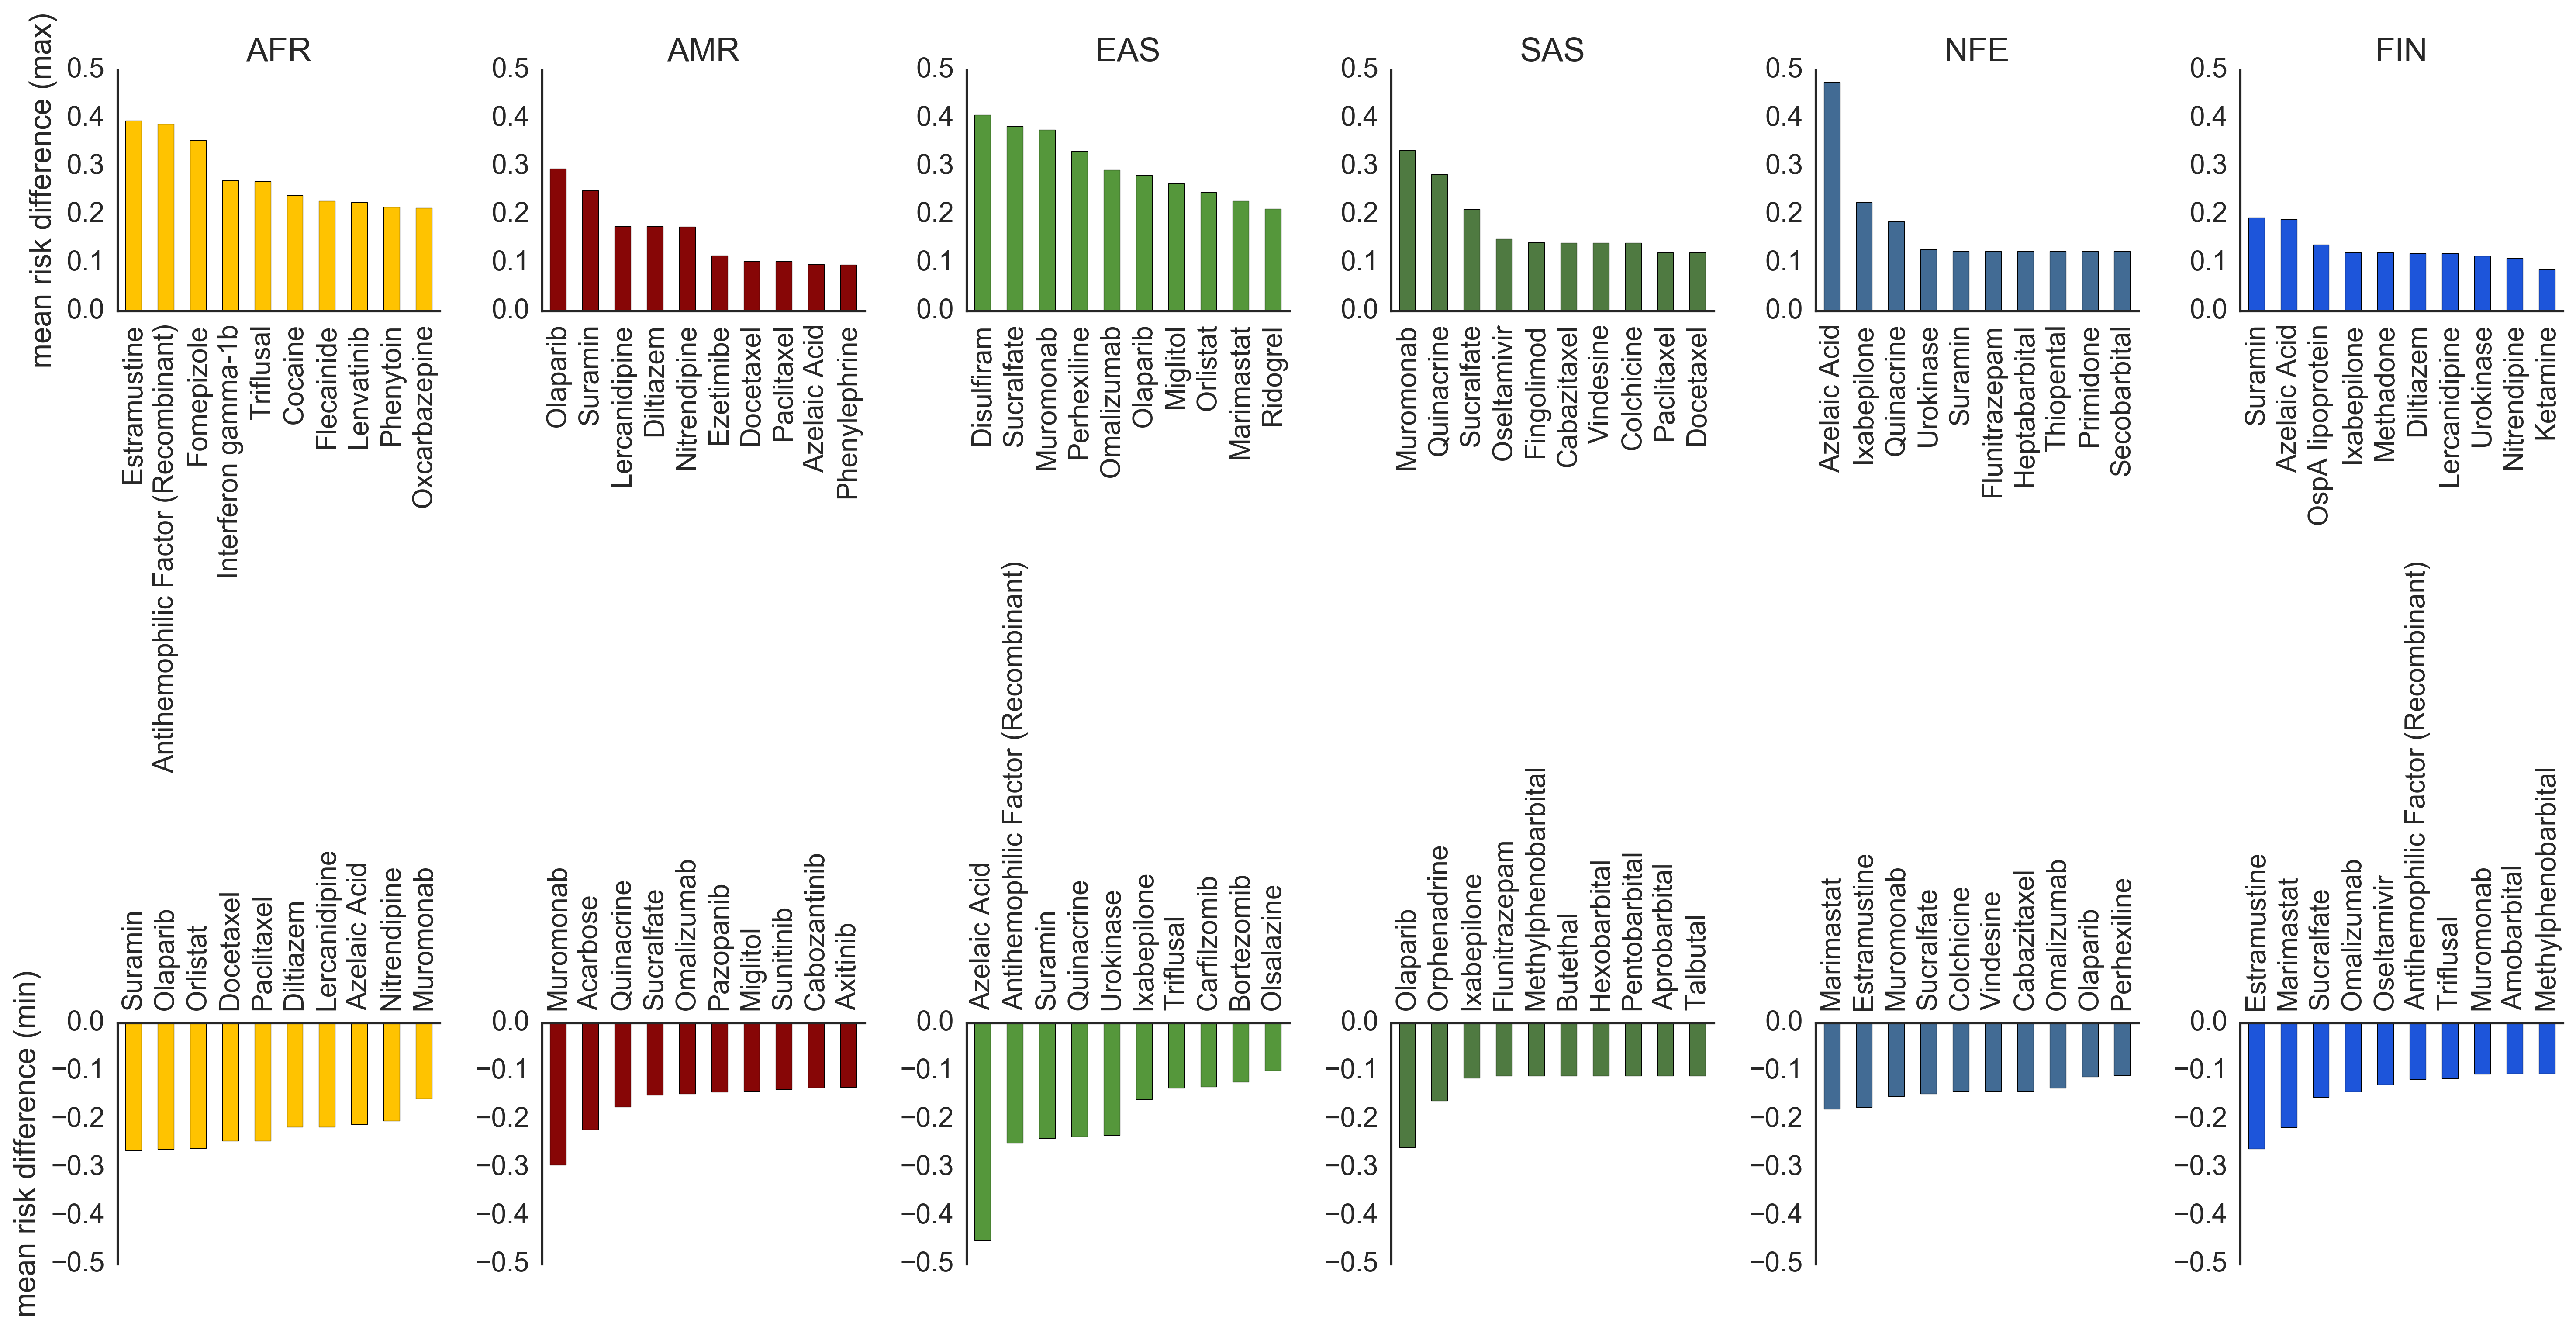

In [143]:
with sns.axes_style('white'):
    fig, axes = plt.subplots(2, 6, figsize=(20, 10), dpi=300, sharey=False, gridspec_kw={'height_ratios':[1, 1]})
    ax1 = axes.reshape(-1)[:6]
    pt.make_pop_specific_barplot(test, 'mean', error=None, extreme=None, ascending=False,
                                 ylim=(0.0, 0.5), axes=ax1, title=True)
    ax2 = axes.reshape(-1)[6:]
    pt.make_pop_specific_barplot(test, 'mean', error=None, extreme=None, ascending=True,
                                 ylim=(-0.5, 0.0), axes=ax2, title=False)
    for ax in ax1:
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90)
    for ax in ax2:
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90)
        ax.xaxis.set_ticks_position('top')
        sns.despine(top=False, bottom=True, ax=ax)
    ax1[0].set_ylabel('mean risk difference (max)')
    ax2[0].set_ylabel('mean risk difference (min)')
    fig.tight_layout()
    fig.savefig(SUPPLEMENT_PATH + "fig3c_pop_specific_drug_differences.pdf")